### 📄 Setup and Package Installation

This section installs all required Python packages for running the pipeline, including:

- `torch` for deep learning
- `scikit-learn` for preprocessing and evaluation metrics
- `matplotlib` and `seaborn` for data visualization
- `umap-learn` for manifold learning and dimensionality reduction
- `statsmodels` for statistical analysis

It also sets up the environment by importing necessary libraries and selecting the appropriate device (`GPU` if available, otherwise `CPU`) for efficient training and computation.


In [ ]:
# 🚀 Install required packages (no pandas upgrade needed!)
!pip install --quiet umap-learn torch scikit-learn matplotlib seaborn statsmodels

# 📦 Imports
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from scipy.spatial import distance
import statsmodels.api as sm
from google.colab import files

# ⚙️ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.5 MB/s eta 0:00:00
✅ Using device: cuda


### 📥 Dataset Upload and Loading

In this cell:

- Users are prompted to upload their final `.pkl` dataset containing the train, validation, and test splits.
- A compatibility patch is applied for certain versions of `pandas` to prevent `Int64Index` import errors.
- The uploaded `.pkl` file is cleaned and parsed to extract the dataset key (e.g., `raw`, `enhanced`, `enhanced_pca`, etc.).
- The contents are stored in a dictionary called `datasets_loaded` with structured access to `X_train`, `X_val`, `X_test`, and their corresponding targets.

This step prepares all necessary data splits for model training and evaluation.


In [ ]:
import pickle
import pandas as pd
import sys
import types
import re
from google.colab import files

# 📤 Upload .pkl file
print("📁 Please upload your final cement .pkl file:")
uploaded = files.upload()

# 🛠️ Patch missing pandas module if needed
numeric_module = types.ModuleType("pandas.core.indexes.numeric")
sys.modules["pandas.core.indexes.numeric"] = numeric_module
numeric_module.Int64Index = pd.Index

# 📦 Load and clean key name
datasets_loaded = {}

for filename in uploaded.keys():
    if filename.endswith(".pkl"):
        # Remove colab (1), (2), etc. suffix and extract key
        clean_name = re.sub(r' \(\d+\)', '', filename)
        key_match = re.match(r'cement_concat_(.+?)_final\.pkl', clean_name)
        key = key_match.group(1) if key_match else "unknown"

        with open(filename, "rb") as f:
            data = pickle.load(f)
            datasets_loaded[key] = {
                "X_train": data["X_train"],
                "X_val": data["X_val"],
                "X_test": data["X_test"],
                "y_train": data["y_train"],
                "y_val": data["y_val"],
                "y_test": data["y_test"],

            }

        print(f"✅ Loaded as datasets_loaded['{key}']")


📁 Please upload your final cement .pkl file:


Saving cement_concat_raw_final.pkl to cement_concat_raw_final.pkl
Saving cement_concat_enhanced_final.pkl to cement_concat_enhanced_final.pkl
✅ Loaded as datasets_loaded['raw']
✅ Loaded as datasets_loaded['enhanced']


### 📊 Visualizing Scaled Target Distributions

This cell generates histograms of the scaled target variable (`y`) across the training, validation, and test splits for each loaded dataset version.

- The histograms help verify that the data splits maintain similar target distributions after scaling.
- A common binning is used (`np.linspace(0, 1, 50)`) because all target values are scaled between 0 and 1.
- Consistent distributions across splits indicate proper stratification and balanced sampling.

These visual checks are important to ensure that model evaluation remains fair and representative.



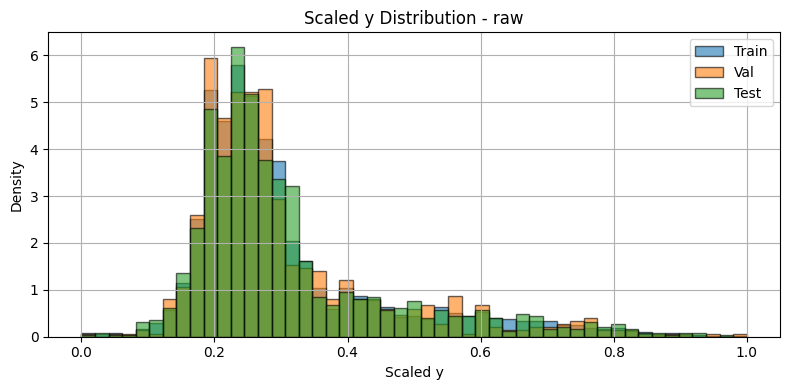

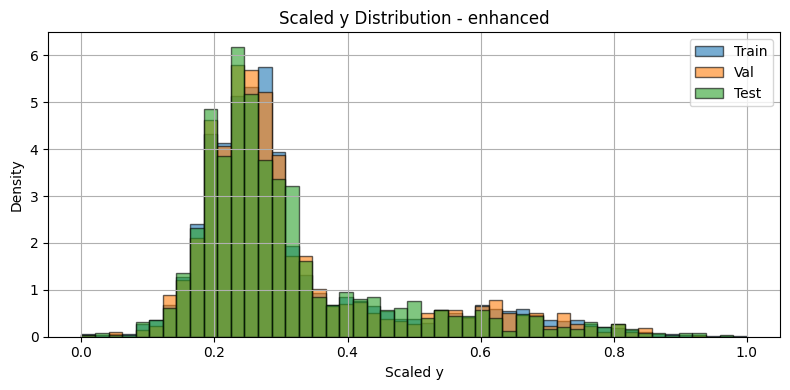

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 📊 Loop through all loaded dataset versions
for key, data in datasets_loaded.items():
    y_train = data['y_train']
    y_val   = data['y_val']
    y_test  = data['y_test']

    plt.figure(figsize=(8, 4))
    bins = np.linspace(0, 1, 50)  # All y values are scaled

    plt.hist(y_train, bins=bins, alpha=0.6, label='Train', edgecolor='black', density=True)
    plt.hist(y_val,   bins=bins, alpha=0.6, label='Val', edgecolor='black', density=True)
    plt.hist(y_test,  bins=bins, alpha=0.6, label='Test', edgecolor='black', density=True)

    plt.title(f'Scaled y Distribution - {key}')
    plt.xlabel('Scaled y')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



### 🧠 Function Definitions for Block-Wise PCA

This section defines reusable functions to:

- **Detect Correlated Feature Groups (`find_correlated_feature_sets`)**: Clusters features with high pairwise correlation (above a specified threshold, default 0.9), helping identify redundancy in the dataset.
- **Optimize PCA per Block (`optimize_pca_block`)**: Applies PCA to each correlated group and selects the minimum number of components that retain at least 95% of variance.
- **Transform Dataset with Block PCA (`apply_pca_blocks_to_dataset`)**: Replaces each correlated group with its PCA-compressed version while preserving original column order and categorical features.

These modular tools support scalable and interpretable dimensionality reduction.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# 🔍 Find blocks of highly correlated features
def find_correlated_feature_sets(df, threshold=0.9):
    corr = df.corr().abs()
    np.fill_diagonal(corr.values, 0)
    features = list(df.columns)

    def expand_feature_set(start_feature):
        visited = set()
        queue = [start_feature]
        while queue:
            current = queue.pop()
            if current not in visited:
                visited.add(current)
                new_features = corr.columns[(corr.loc[current] > threshold)].tolist()
                queue.extend([f for f in new_features if f not in visited])
        return visited

    all_sets = [expand_feature_set(f) for f in features]
    sets = [s for s in all_sets if len(s) > 1]

    # Deduplicate
    unique_sets = []
    for s in sets:
        if not any(s == other for other in unique_sets):
            unique_sets.append(s)

    # Remove overlaps
    changed = True
    while changed:
        changed = False
        new_sets = []

        for i, A in enumerate(unique_sets):
            keep_A = True
            for j, B in enumerate(unique_sets):
                if i == j:
                    continue
                if A == B or A.issubset(B):
                    keep_A = False
                    break
                elif len(A & B) > 0:
                    if len(A) < len(B):
                        B -= A
                        changed = True
                    else:
                        A -= B
                        changed = True
            if keep_A and len(A) > 1:
                new_sets.append(A)

        deduped = []
        for s in new_sets:
            if not any(s == other for other in deduped):
                deduped.append(s)

        if len(deduped) != len(unique_sets):
            changed = True
        unique_sets = deduped

    return [sorted(s) for s in unique_sets]

# 📉 Optimize PCA for a block
def optimize_pca_block(df_block, block_name="block"):
    X = df_block.values
    max_components = min(10, X.shape[1])
    variances = []

    for n in range(1, max_components + 1):
        pca = PCA(n_components=n)
        pca.fit(X)
        variances.append(np.sum(pca.explained_variance_ratio_))

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, max_components + 1), variances, marker='o')
    plt.axhline(0.95, color='red', linestyle='--')
    plt.title(f"{block_name} — Variance Retained")
    plt.xlabel("n_components")
    plt.ylabel("Cumulative Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Select number of components for 95% variance
    for n, v in zip(range(1, max_components + 1), variances):
        if v >= 0.95:
            break
    else:
        n = max_components

    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    return pd.DataFrame(X_pca, columns=[f"{block_name}_pca{i+1}" for i in range(n)], index=df_block.index), pca


def apply_pca_blocks_to_dataset(X_train, X_val, X_test, name="Dataset", corr_threshold=0.9):
    print(f"\n📦 Processing {name}...")

    # 🔍 Exclude dummy features
    exclude_cols = [c for c in X_train.columns if c.startswith("Type_") or c.startswith("Process_")]
    include_cols = [c for c in X_train.columns if c not in exclude_cols]
    X_train_base = X_train[include_cols].copy()
    X_val_base = X_val[include_cols].copy()
    X_test_base = X_test[include_cols].copy()

    # 🚨 Track column order
    original_order = list(X_train.columns)

    # 🔄 Find correlated feature blocks
    blocks = find_correlated_feature_sets(X_train_base, threshold=corr_threshold)
    print(f"🔍 Found {len(blocks)} correlated blocks in total with correlation threshold = {corr_threshold}.")

    X_train_new = X_train_base.copy()
    X_val_new = X_val_base.copy()
    X_test_new = X_test_base.copy()

    for i, block in enumerate(blocks, 1):
        print(f"\n🔧 Block {i}: {block}")
        block_name = f"{name}_block{i}"
        pca_df_train, pca_model = optimize_pca_block(X_train_base[block], block_name)

        pca_df_val = pd.DataFrame(
            pca_model.transform(X_val_base[block]),
            columns=pca_df_train.columns,
            index=X_val.index
        )

        pca_df_test = pd.DataFrame(
            pca_model.transform(X_test_base[block]),
            columns=pca_df_train.columns,
            index=X_test.index
        )

        # Replace block
        for df, df_pca in zip(
            [X_train_new, X_val_new, X_test_new],
            [pca_df_train, pca_df_val, pca_df_test]
        ):
            df.drop(columns=block, inplace=True)
            df[df_pca.columns] = df_pca

    # 🔁 Reinsert excluded cols and reorder
    X_train_final = pd.concat([X_train_new, X_train[exclude_cols]], axis=1)
    X_val_final   = pd.concat([X_val_new, X_val[exclude_cols]], axis=1)
    X_test_final  = pd.concat([X_test_new, X_test[exclude_cols]], axis=1)

    # 🧩 Reorder
    def reorder(df):
        ordered = []
        seen = set()
        for col in original_order:
            if col in df.columns:
                ordered.append(col)
                seen.add(col)
        # Add any PCA cols not already placed
        for col in df.columns:
            if col not in seen:
                ordered.append(col)
        return df[ordered]

    X_train_final = reorder(X_train_final)
    X_val_final   = reorder(X_val_final)
    X_test_final  = reorder(X_test_final)

    # ✅ Safety checks
    assert X_train_final.shape[0] == X_train.shape[0]
    assert X_val_final.shape[0] == X_val.shape[0]
    assert X_test_final.shape[0] == X_test.shape[0]

    print(f"\n✅ {name} — Final shapes: {X_train_final.shape} (train), {X_val_final.shape} (val), {X_test_final.shape} (test)")
    return X_train_final, X_val_final, X_test_final


### ⚙️ Apply Block-Wise PCA to All Datasets

This loop iterates through each dataset in `datasets_loaded` and applies block-wise PCA using the previously defined functions. If dimensionality is reduced, a new version of the dataset is saved with the suffix `_pca`.

- Helps reduce redundancy by compressing correlated feature blocks.
- Ensures PCA is only retained if it results in actual dimensionality reduction.
- Original and PCA-transformed datasets are both preserved for later comparison.



🔁 Trying PCA on: raw

📦 Processing raw...
🔍 Found 3 correlated blocks in total with correlation threshold = 0.9.

🔧 Block 1: ['BlaineS', 'd10']


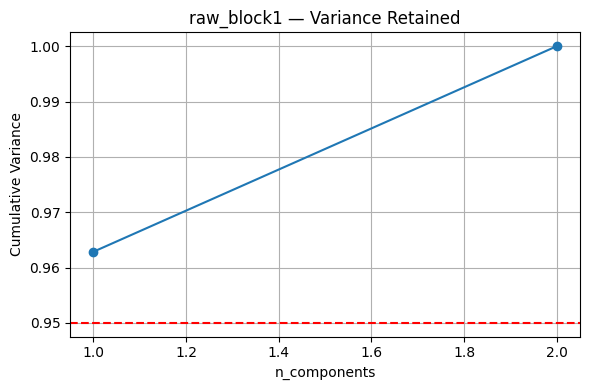


🔧 Block 2: ['305', '454', 'd50', 'd63', 'd90']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


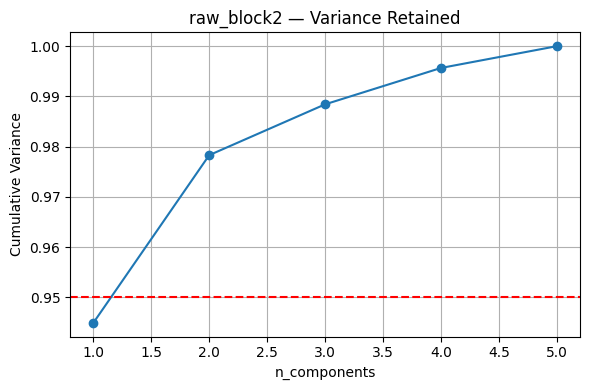

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 3: ['753', '902']


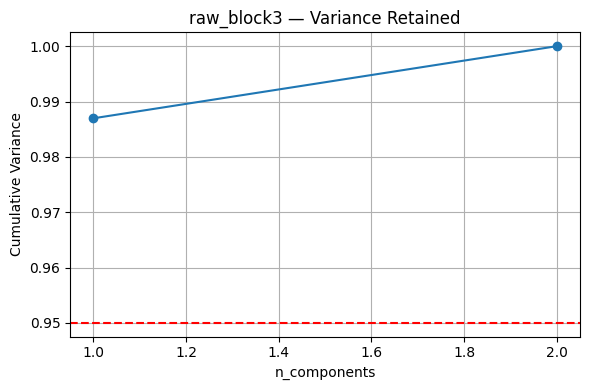

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



✅ raw — Final shapes: (4156, 53) (train), (734, 53) (val), (1224, 53) (test)
✅ Added PCA-transformed version as 'raw_pca'

🔁 Trying PCA on: enhanced

📦 Processing enhanced...
🔍 Found 62 correlated blocks in total with correlation threshold = 0.9.

🔧 Block 1: ['L', 'whiteness']


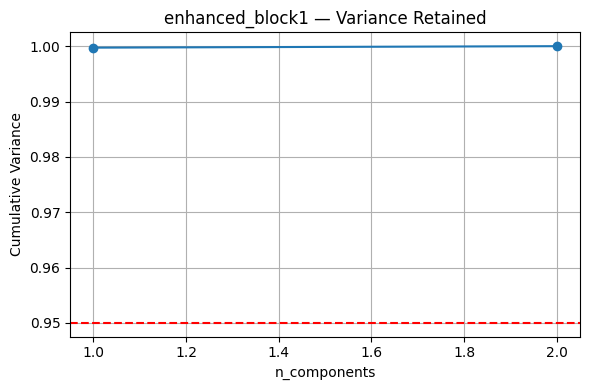


🔧 Block 2: ['L_div_a_plus_b', 'b']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


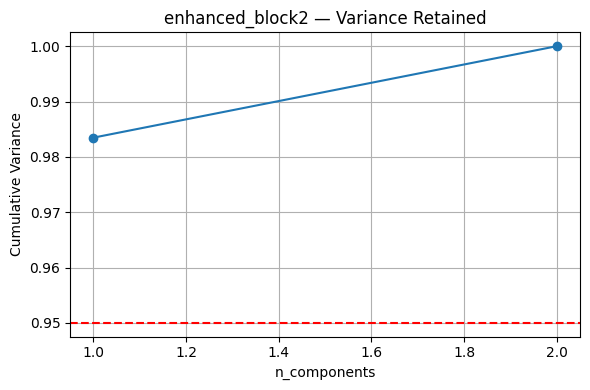

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 3: ['305', '454', 'BlaineS', 'Blaine_div_d50', 'd10', 'd10_div_d90', 'd50', 'd63', 'd90', 'n']


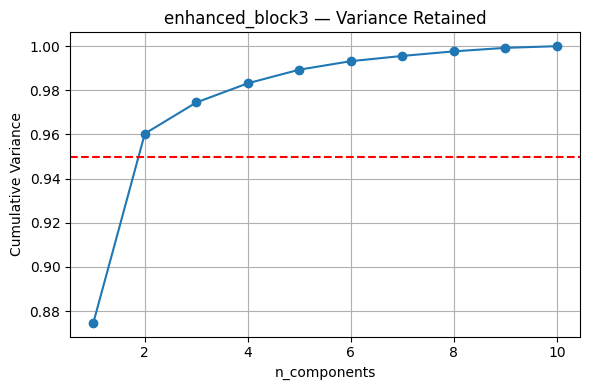

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 4: ['753', '902']


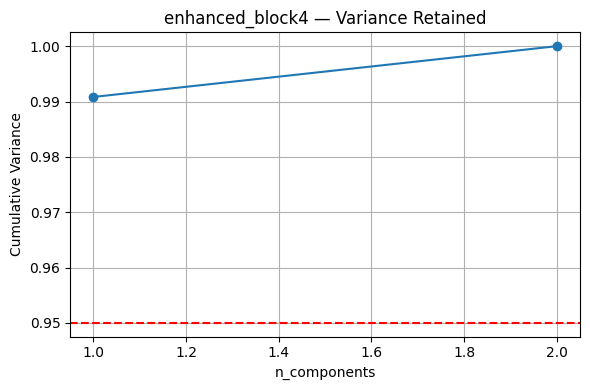

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 5: ['Chem_ilr_1', 'Chem_ilr_2', 'Chem_ilr_3']


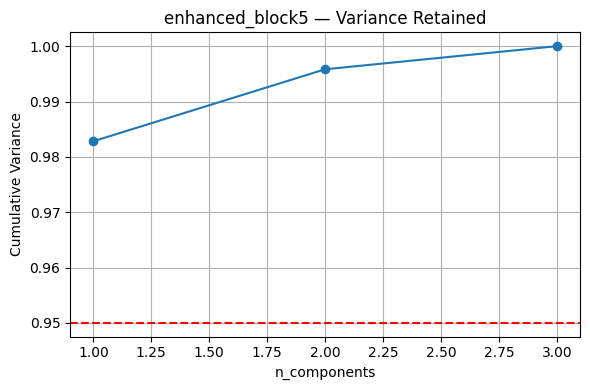

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 6: ['Chem_10_div_Chem_1', 'Chem_10_div_Chem_2', 'Chem_10_div_Chem_3', 'Chem_10_div_Chem_7', 'Chem_10_div_Chem_8', 'Chem_10_div_Chem_9', 'Chem_10_div_Phase_1', 'Chem_10_div_Phase_12', 'Chem_10_div_Phase_4', 'Chem_10_div_Phase_7', 'Chem_1_div_Chem_10', 'Chem_2_div_Chem_10', 'Chem_3_div_Chem_10', 'Chem_7_div_Chem_10', 'Chem_8_div_Chem_10', 'Chem_9_div_Chem_10', 'Chem_ilr_9']


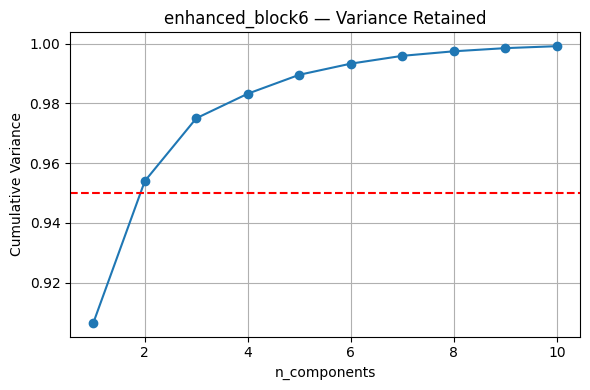

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 7: ['Chem_10_div_Chem_11', 'Chem_11_div_Chem_10', 'Chem_ilr_10']


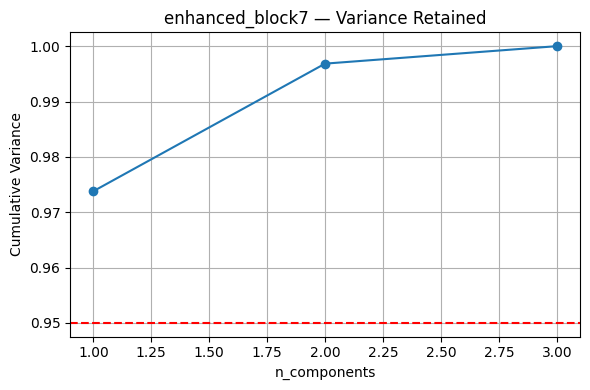

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 8: ['Phase_ilr_1', 'Phase_ilr_4', 'Phase_ilr_5', 'Phase_ilr_6', 'Phase_ilr_7']


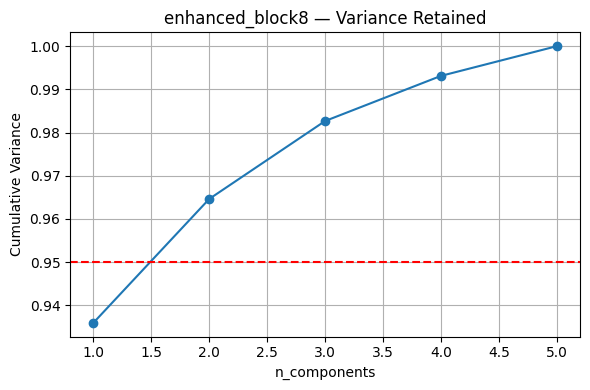

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 9: ['Phase_11_div_Phase_13', 'Phase_ilr_11']


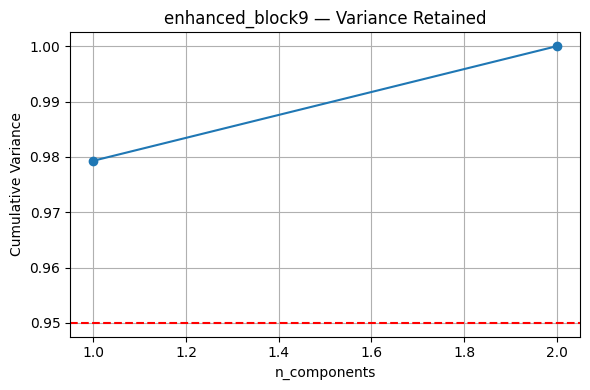

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 10: ['Phase_13_div_Phase_1', 'Phase_ilr_12']


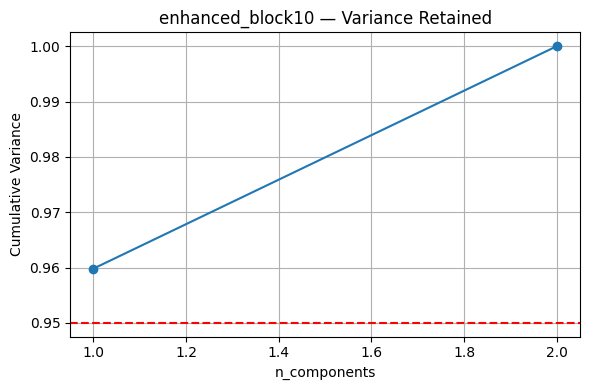

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 11: ['chem_total_div_water', 'water']


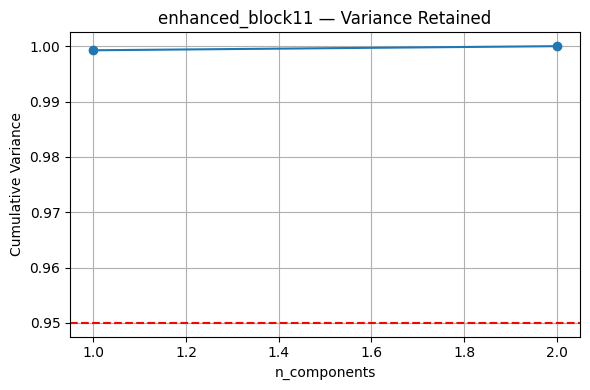

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 12: ['Chem_1_div_Chem_2', 'Chem_2_div_Chem_1']


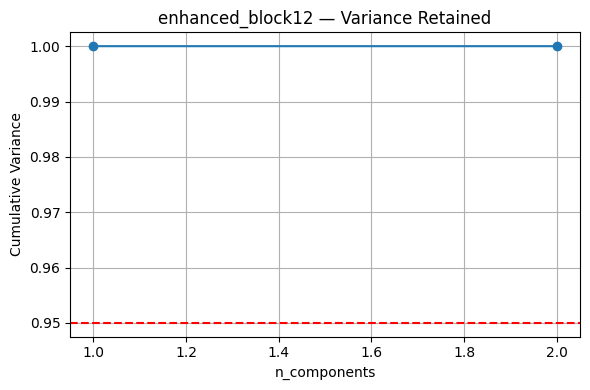

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 13: ['Chem_1_div_Chem_3', 'Chem_3_div_Chem_1']


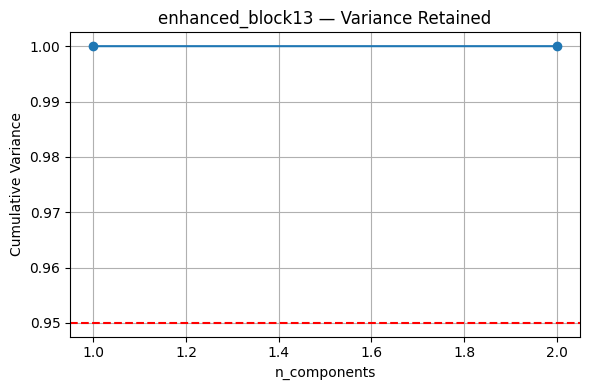

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 14: ['Chem_1_div_Chem_4', 'Chem_1_div_Chem_9', 'Chem_1_div_Phase_2', 'Chem_1_div_Phase_3', 'Chem_1_div_Phase_4', 'Chem_2_div_Chem_4', 'Chem_2_div_Chem_7', 'Chem_2_div_Chem_9', 'Chem_2_div_Phase_2', 'Chem_2_div_Phase_3', 'Chem_2_div_Phase_4', 'Chem_3_div_Chem_4', 'Chem_3_div_Chem_7', 'Chem_3_div_Chem_9', 'Chem_3_div_Phase_2', 'Chem_3_div_Phase_3', 'Chem_3_div_Phase_4', 'Chem_4_div_Chem_1', 'Chem_4_div_Chem_2', 'Chem_4_div_Chem_3', 'Chem_4_div_Chem_7', 'Chem_4_div_Chem_8', 'Chem_4_div_Phase_1', 'Chem_4_div_Phase_4', 'Chem_4_div_Phase_6', 'Chem_4_div_Phase_7', 'Chem_5_div_Chem_9', 'Chem_5_div_Phase_4', 'Chem_6_div_Chem_9', 'Chem_6_div_Phase_4', 'Chem_7_div_Chem_2', 'Chem_7_div_Chem_3', 'Chem_7_div_Chem_4', 'Chem_7_div_Chem_9', 'Chem_7_div_Phase_1', 'Chem_7_div_Phase_2', 'Chem_7_div_Phase_3', 'Chem_7_div_Phase_4', 'Chem_8_div_Chem_4', 'Chem_8_div_Chem_9', 'Chem_8_div_Phase_3', 'Chem_8_div_Phase_4', 'Chem_9_div_Chem_1', 'Chem_9_div_Chem_2', 'Chem_9_div_Chem_3', 'Chem_9_div_Chem_5',

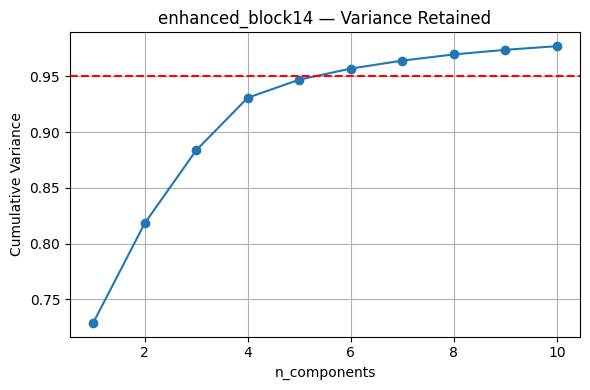


🔧 Block 15: ['Chem_1_div_Chem_5', 'Chem_2_div_Chem_5', 'Chem_3_div_Chem_5', 'Chem_5_div_Chem_1', 'Chem_5_div_Chem_2', 'Chem_5_div_Chem_3', 'Chem_5_div_Chem_7', 'Chem_5_div_Phase_1', 'Chem_7_div_Chem_5']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


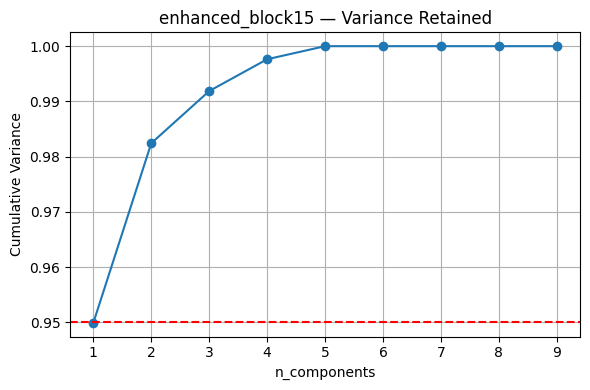

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 16: ['Chem_1_div_Chem_6', 'Chem_2_div_Chem_6', 'Chem_3_div_Chem_6', 'Chem_6_div_Chem_1', 'Chem_6_div_Chem_2', 'Chem_6_div_Chem_3', 'Chem_6_div_Chem_7', 'Chem_6_div_Chem_8', 'Chem_6_div_Phase_1', 'Chem_7_div_Chem_6', 'Chem_8_div_Chem_6', 'Chem_8_div_Phase_2']


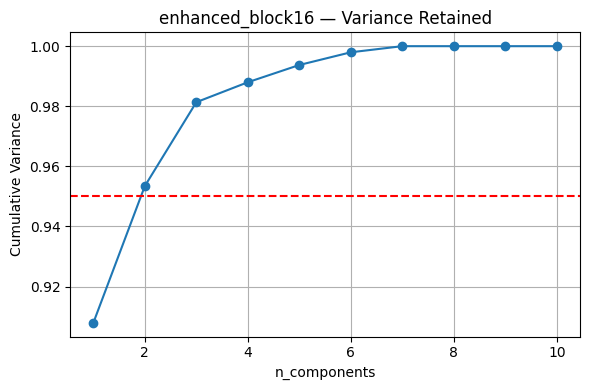

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 17: ['Chem_1_div_Chem_7', 'Chem_7_div_Chem_1']


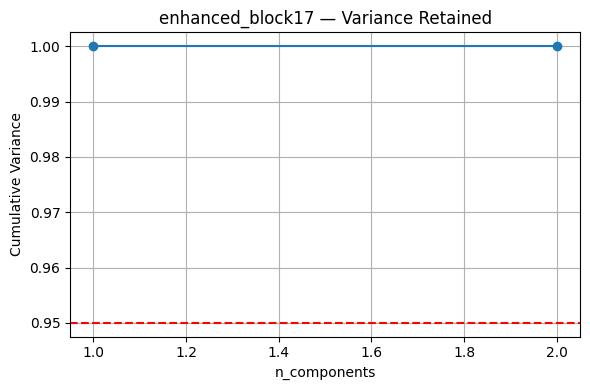

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 18: ['Chem_1_div_Chem_8', 'Chem_2_div_Chem_8', 'Chem_3_div_Chem_8', 'Chem_8_div_Chem_1', 'Chem_8_div_Chem_2', 'Chem_8_div_Chem_3', 'Chem_8_div_Phase_1']


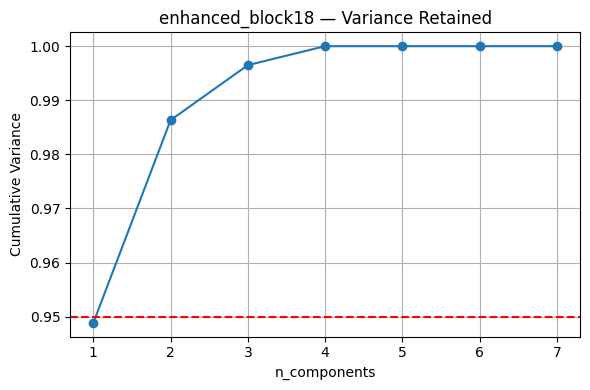

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 19: ['Chem_11_div_Chem_1', 'Chem_11_div_Chem_2', 'Chem_11_div_Chem_3', 'Chem_11_div_Chem_7', 'Chem_11_div_Chem_8', 'Chem_11_div_Chem_9', 'Chem_11_div_Phase_1', 'Chem_11_div_Phase_4', 'Chem_11_div_Phase_7', 'Chem_1_div_Chem_11', 'Chem_2_div_Chem_11', 'Chem_3_div_Chem_11', 'Chem_7_div_Chem_11', 'Chem_8_div_Chem_11', 'Chem_9_div_Chem_11']


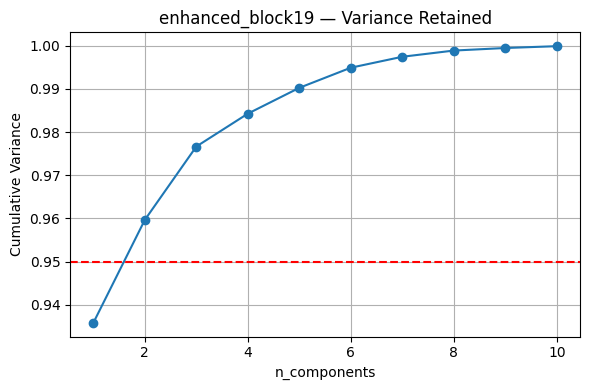

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 20: ['Chem_2_div_Chem_3', 'Chem_3_div_Chem_2']


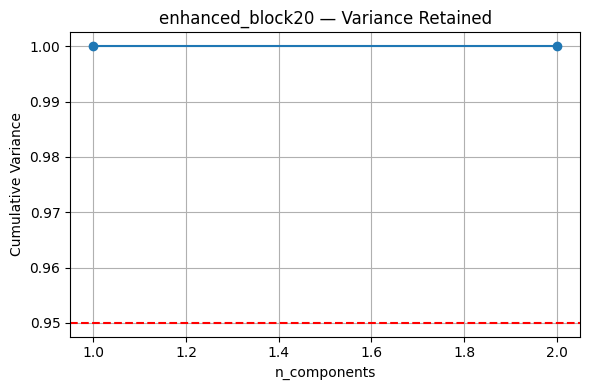

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 21: ['Chem_4_div_Chem_5', 'Chem_5_div_Chem_4']


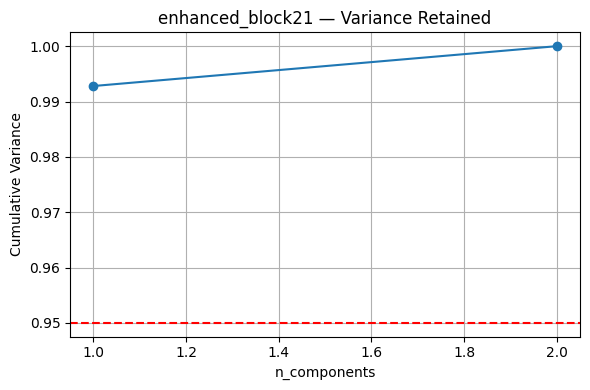

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 22: ['Chem_4_div_Chem_6', 'Chem_4_div_Phase_2', 'Chem_6_div_Chem_4']


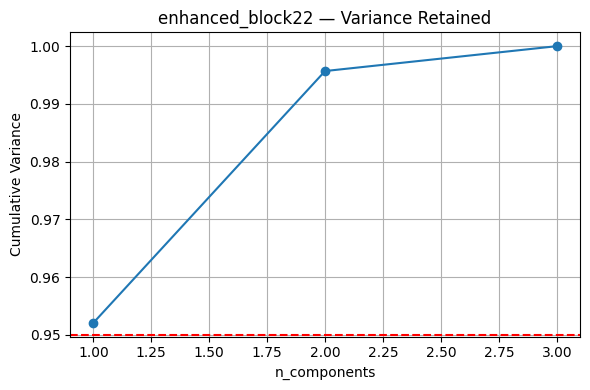

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 23: ['Chem_4_div_Chem_9', 'Chem_9_div_Chem_4']


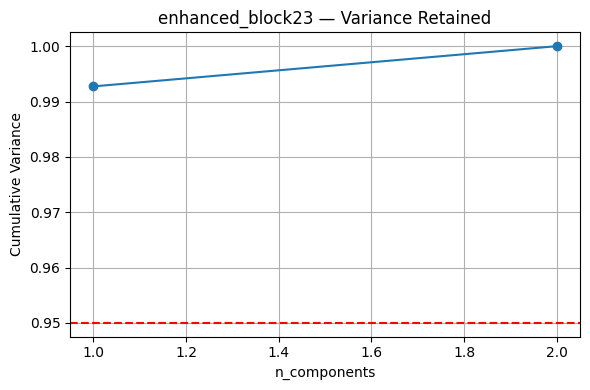

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 24: ['Chem_10_div_Chem_4', 'Chem_10_div_Chem_6', 'Chem_10_div_Phase_11', 'Chem_10_div_Phase_2', 'Chem_10_div_Phase_9', 'Chem_4_div_Chem_10', 'Chem_6_div_Chem_10']


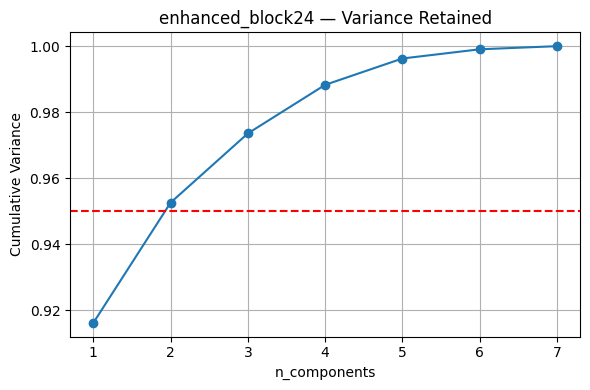

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 25: ['Chem_11_div_Chem_4', 'Chem_4_div_Chem_11']


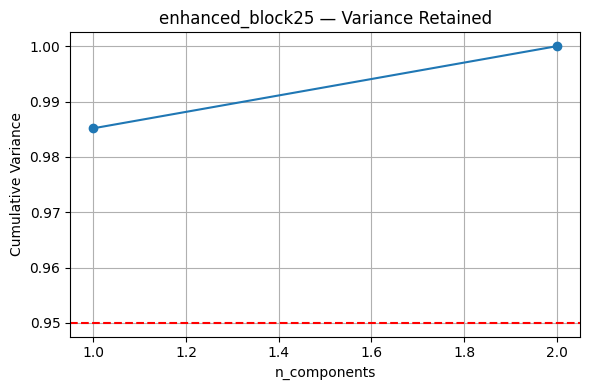

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 26: ['Chem_5_div_Chem_6', 'Chem_6_div_Chem_5']


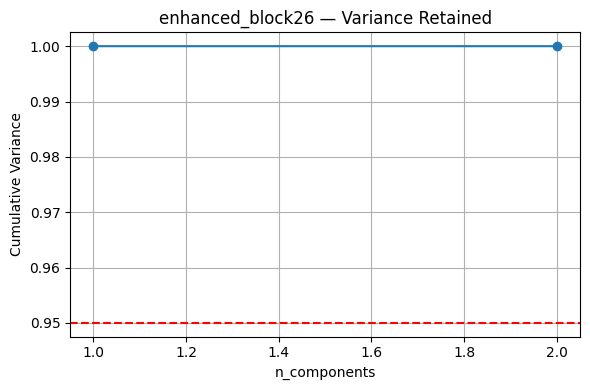

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 27: ['Chem_5_div_Chem_8', 'Chem_8_div_Chem_5']


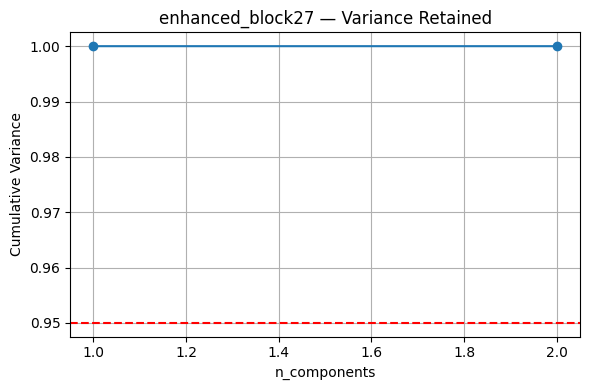

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 28: ['Chem_10_div_Chem_5', 'Chem_5_div_Chem_10']


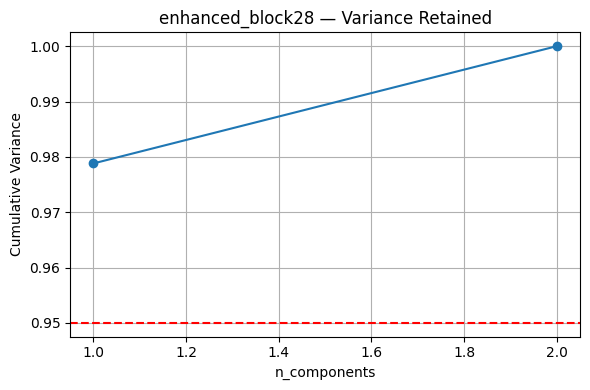

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 29: ['Chem_11_div_Chem_5', 'Chem_5_div_Chem_11']


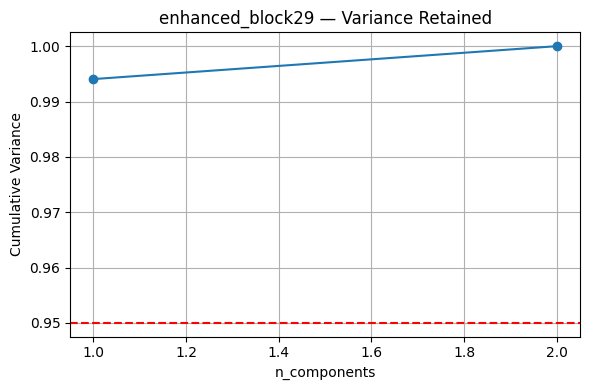

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 30: ['Chem_11_div_Chem_6', 'Chem_11_div_Phase_2', 'Chem_11_div_Phase_9', 'Chem_6_div_Chem_11']


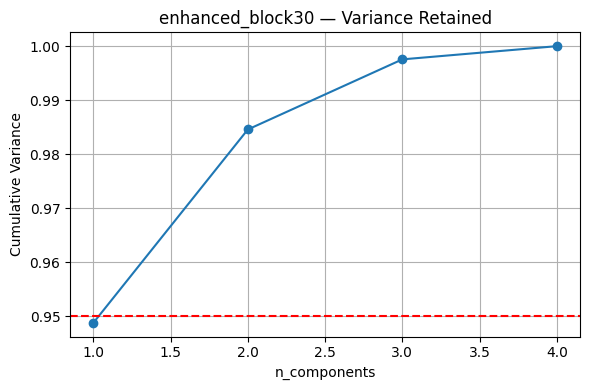


🔧 Block 31: ['Chem_7_div_Chem_8', 'Chem_8_div_Chem_7']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


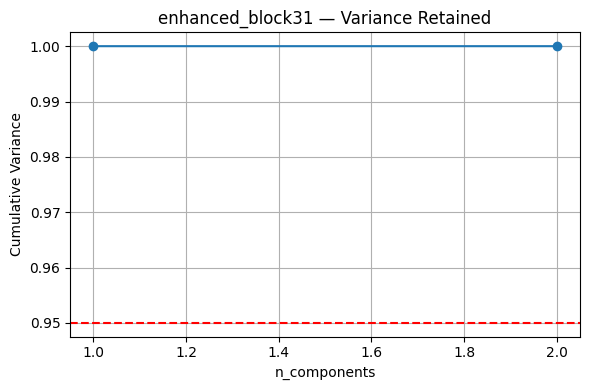

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 32: ['Chem_1_div_Phase_5', 'Chem_2_div_Phase_5', 'Chem_3_div_Phase_5', 'Chem_7_div_Phase_5', 'Chem_8_div_Phase_5', 'Phase_1_div_Phase_5', 'Phase_5_div_Phase_1']


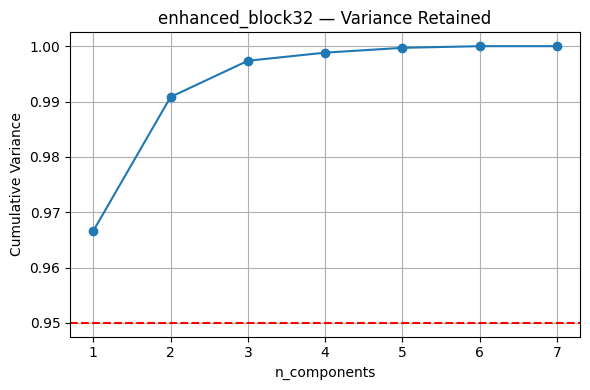

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 33: ['Chem_1_div_Phase_6', 'Chem_2_div_Phase_6', 'Chem_3_div_Phase_6', 'Chem_7_div_Phase_6', 'Phase_1_div_Phase_6', 'Phase_6_div_Phase_1']

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


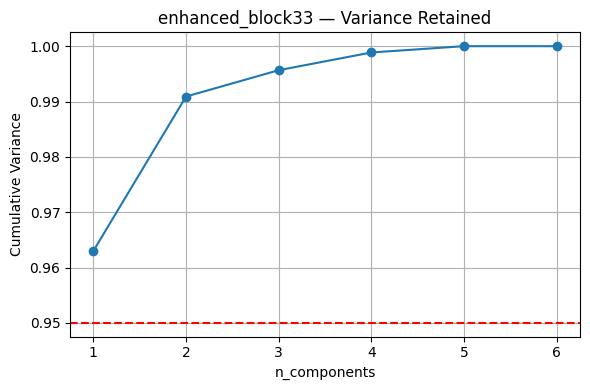

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 34: ['Chem_1_div_Phase_7', 'Chem_2_div_Phase_7', 'Chem_3_div_Phase_7', 'Chem_7_div_Phase_7', 'Chem_8_div_Phase_7', 'Phase_1_div_Phase_7', 'Phase_7_div_Phase_1']


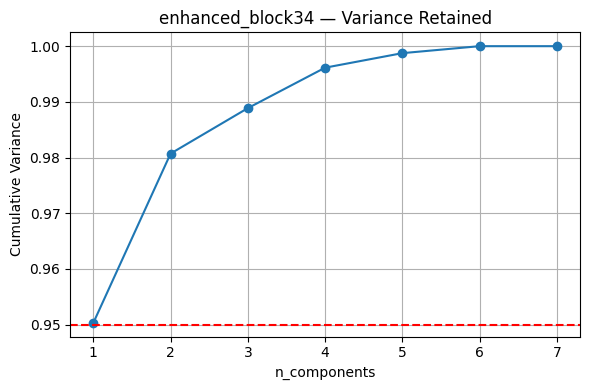


🔧 Block 35: ['Chem_1_div_Phase_8', 'Chem_2_div_Phase_8', 'Chem_3_div_Phase_8', 'Chem_7_div_Phase_8', 'Chem_8_div_Phase_8', 'Chem_9_div_Phase_8', 'Phase_1_div_Phase_8', 'Phase_4_div_Phase_8', 'Phase_7_div_Phase_8', 'Phase_8_div_Phase_1', 'Phase_8_div_Phase_4', 'Phase_8_div_Phase_7']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


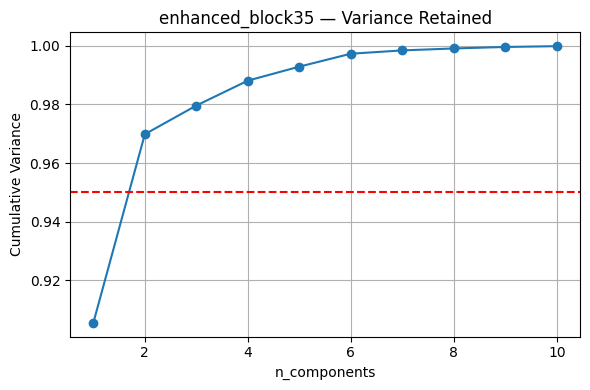

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 36: ['Chem_1_div_Phase_9', 'Chem_2_div_Phase_9', 'Chem_3_div_Phase_9', 'Chem_5_div_Phase_9', 'Chem_6_div_Phase_6', 'Chem_7_div_Phase_9', 'Chem_8_div_Phase_9', 'Chem_9_div_Phase_9', 'Phase_1_div_Phase_9', 'Phase_2_div_Phase_6', 'Phase_3_div_Phase_9', 'Phase_5_div_Phase_9', 'Phase_6_div_Phase_2', 'Phase_6_div_Phase_9', 'Phase_7_div_Phase_9']


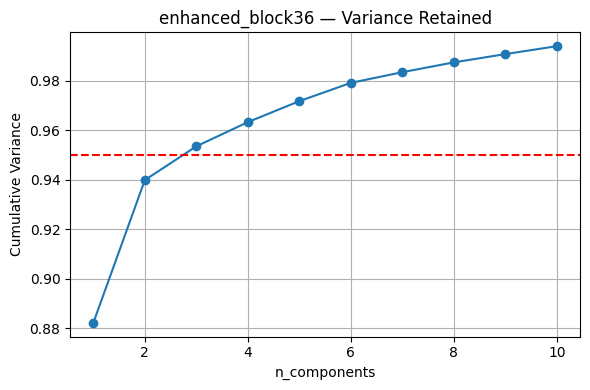

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 37: ['Phase_9_div_Phase_1', 'Phase_9_div_Phase_4']


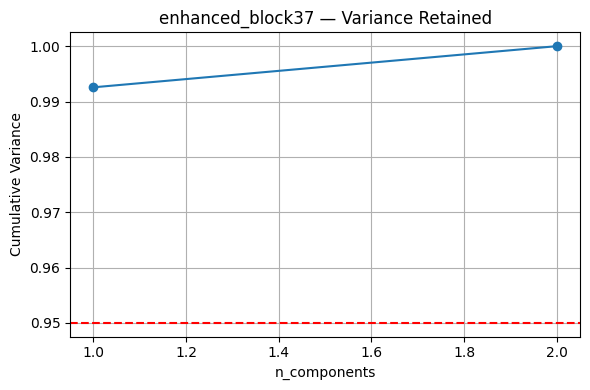

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 38: ['Chem_1_div_Phase_10', 'Chem_2_div_Phase_10', 'Chem_3_div_Phase_10', 'Chem_7_div_Phase_10', 'Chem_8_div_Phase_10', 'Chem_9_div_Phase_10', 'Phase_1_div_Phase_10', 'Phase_4_div_Phase_10', 'Phase_7_div_Phase_10']


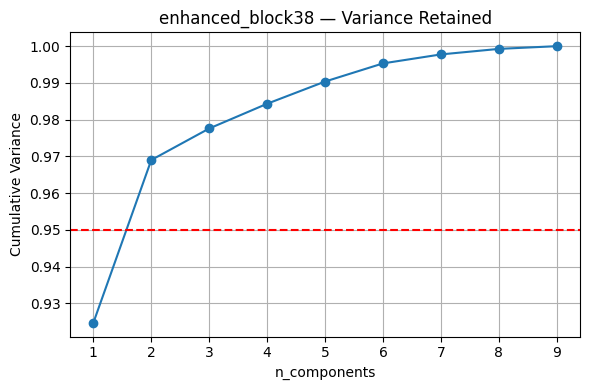

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 39: ['Phase_10_div_Phase_1', 'Phase_10_div_Phase_11', 'Phase_10_div_Phase_12', 'Phase_10_div_Phase_13', 'Phase_10_div_Phase_2', 'Phase_10_div_Phase_3', 'Phase_10_div_Phase_4', 'Phase_10_div_Phase_5', 'Phase_10_div_Phase_6', 'Phase_10_div_Phase_7', 'Phase_10_div_Phase_8', 'Phase_10_div_Phase_9']


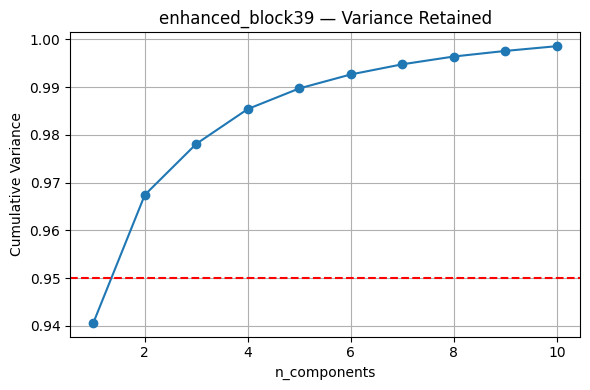


🔧 Block 40: ['Chem_1_div_Phase_11', 'Chem_2_div_Phase_11', 'Chem_3_div_Phase_11', 'Chem_5_div_Phase_11', 'Chem_7_div_Phase_11', 'Chem_8_div_Phase_11', 'Chem_9_div_Phase_11', 'Phase_11_div_Phase_1', 'Phase_11_div_Phase_12', 'Phase_11_div_Phase_4', 'Phase_11_div_Phase_5', 'Phase_11_div_Phase_6', 'Phase_11_div_Phase_7', 'Phase_1_div_Phase_11', 'Phase_4_div_Phase_11', 'Phase_5_div_Phase_11', 'Phase_6_div_Phase_11', 'Phase_7_div_Phase_11']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


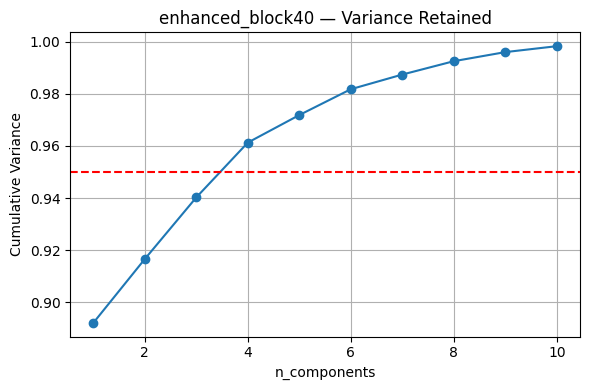

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 41: ['Chem_2_div_Phase_12', 'Chem_3_div_Phase_12', 'Phase_1_div_Phase_12']


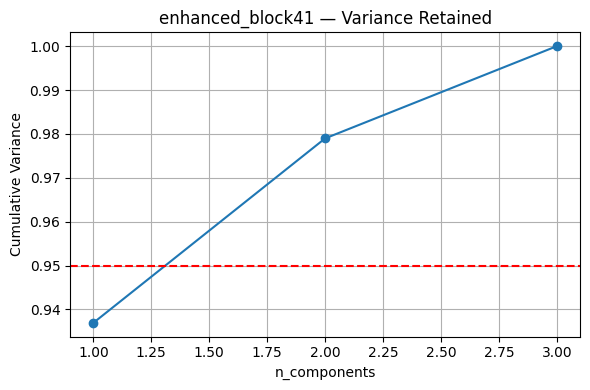


🔧 Block 42: ['Chem_2_div_Phase_13', 'Chem_3_div_Phase_13', 'Chem_9_div_Phase_13', 'Phase_1_div_Phase_13', 'Phase_4_div_Phase_13', 'Phase_7_div_Phase_13']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


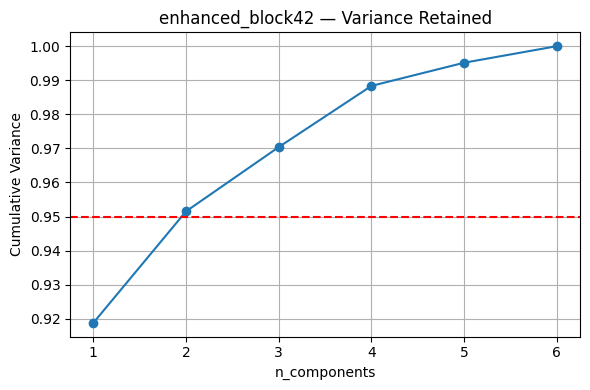

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 43: ['Chem_6_div_Phase_3', 'Phase_2_div_Phase_3', 'Phase_3_div_Phase_2']


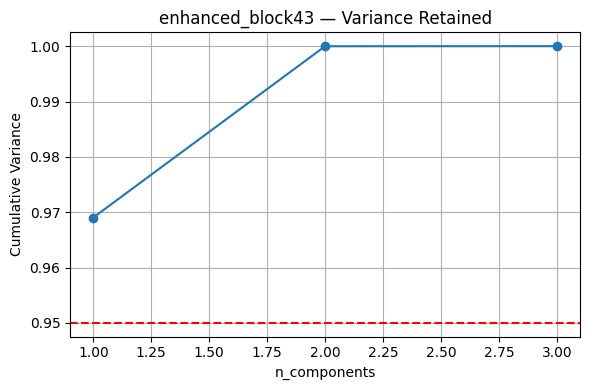

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 44: ['Chem_5_div_Phase_5', 'Chem_6_div_Phase_5', 'Phase_2_div_Phase_5', 'Phase_3_div_Phase_5', 'Phase_5_div_Phase_2', 'Phase_5_div_Phase_3']


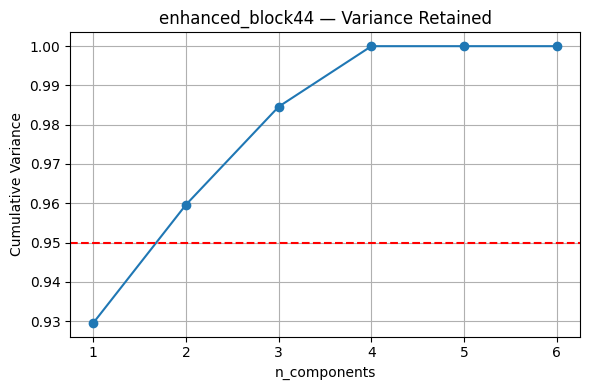


🔧 Block 45: ['Chem_6_div_Phase_7', 'Phase_2_div_Phase_7', 'Phase_7_div_Phase_2']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


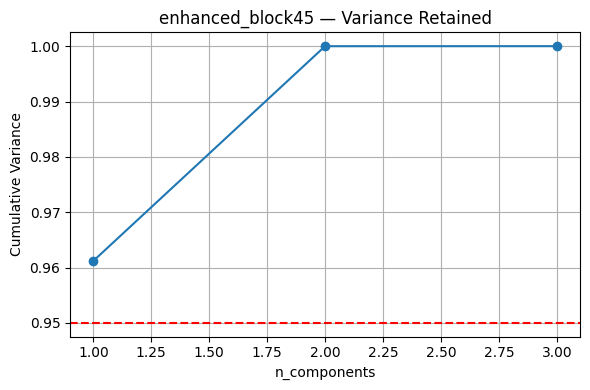

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 46: ['Chem_6_div_Phase_8', 'Phase_2_div_Phase_8', 'Phase_8_div_Phase_2']


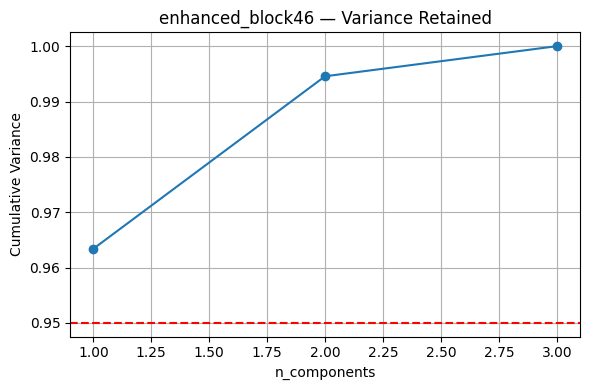

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 47: ['Chem_6_div_Phase_9', 'Phase_2_div_Phase_9']


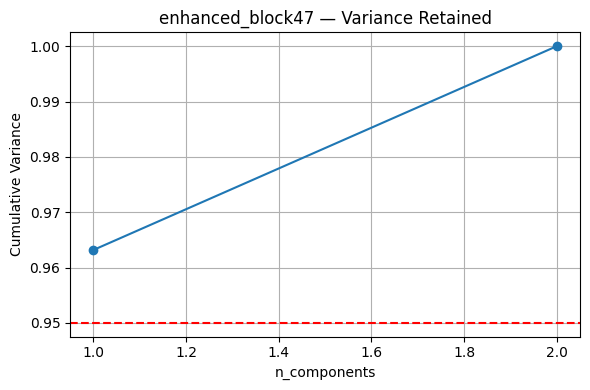

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 48: ['Phase_9_div_Phase_10', 'Phase_9_div_Phase_11', 'Phase_9_div_Phase_12', 'Phase_9_div_Phase_13', 'Phase_9_div_Phase_2', 'Phase_9_div_Phase_3', 'Phase_9_div_Phase_5', 'Phase_9_div_Phase_6', 'Phase_9_div_Phase_7', 'Phase_9_div_Phase_8']


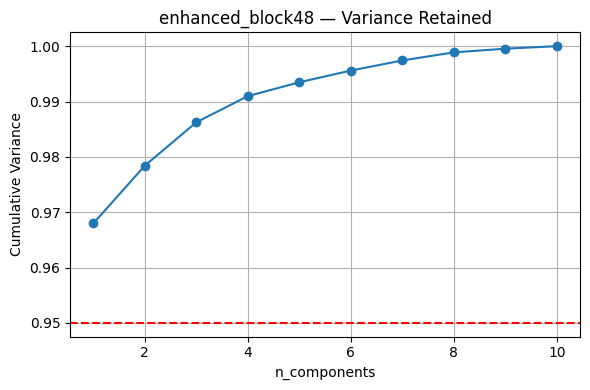


🔧 Block 49: ['Chem_5_div_Phase_10', 'Chem_6_div_Phase_10', 'Phase_2_div_Phase_10', 'Phase_3_div_Phase_10']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


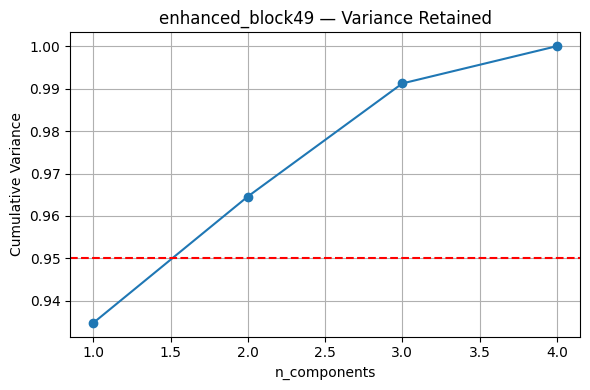

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 50: ['Phase_11_div_Phase_2', 'Phase_2_div_Phase_11']


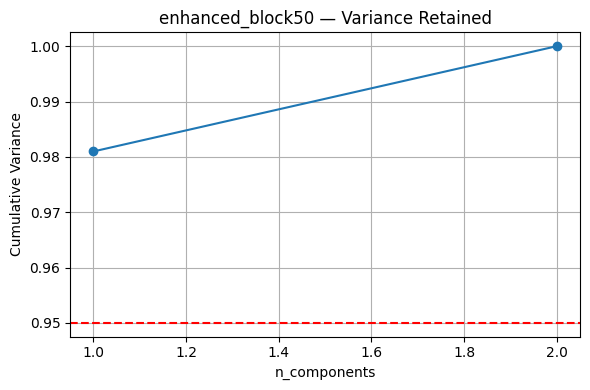

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 51: ['Chem_6_div_Phase_13', 'Phase_2_div_Phase_13']


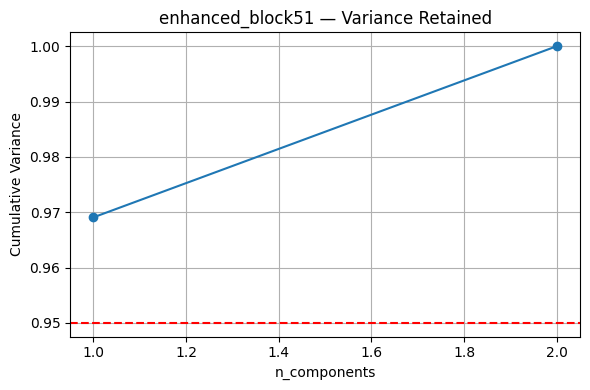

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 52: ['Phase_3_div_Phase_6', 'Phase_6_div_Phase_3']


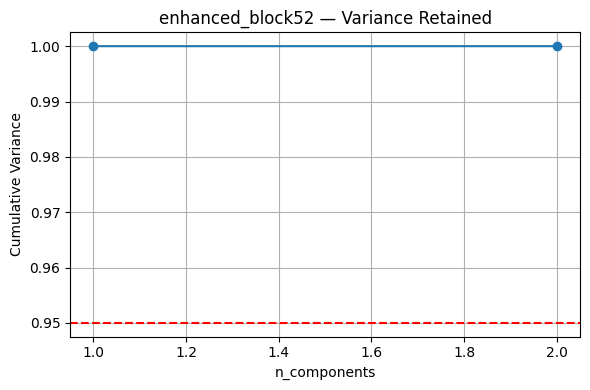

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 53: ['Phase_3_div_Phase_8', 'Phase_8_div_Phase_3']


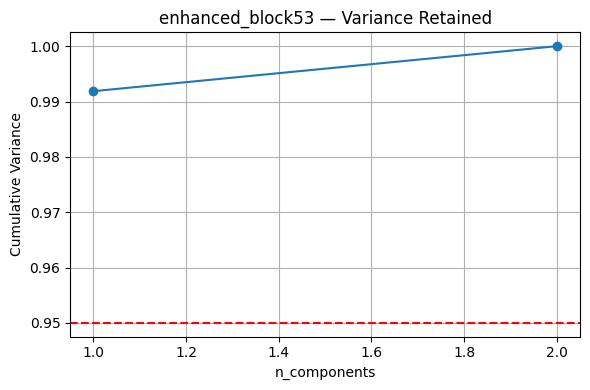

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 54: ['Phase_11_div_Phase_3', 'Phase_11_div_Phase_8', 'Phase_3_div_Phase_11', 'Phase_8_div_Phase_11']


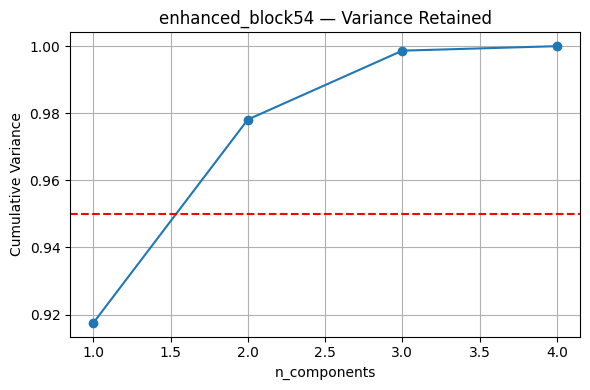

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 55: ['Phase_12_div_Phase_10', 'Phase_12_div_Phase_11', 'Phase_12_div_Phase_13', 'Phase_12_div_Phase_3', 'Phase_12_div_Phase_5', 'Phase_12_div_Phase_6', 'Phase_12_div_Phase_7', 'Phase_12_div_Phase_8', 'Phase_12_div_Phase_9']


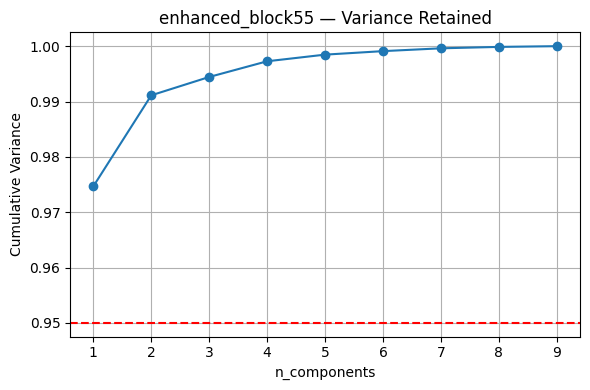

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 56: ['Phase_13_div_Phase_10', 'Phase_13_div_Phase_11', 'Phase_13_div_Phase_12', 'Phase_13_div_Phase_3', 'Phase_13_div_Phase_5', 'Phase_13_div_Phase_6', 'Phase_13_div_Phase_7', 'Phase_13_div_Phase_8', 'Phase_13_div_Phase_9']


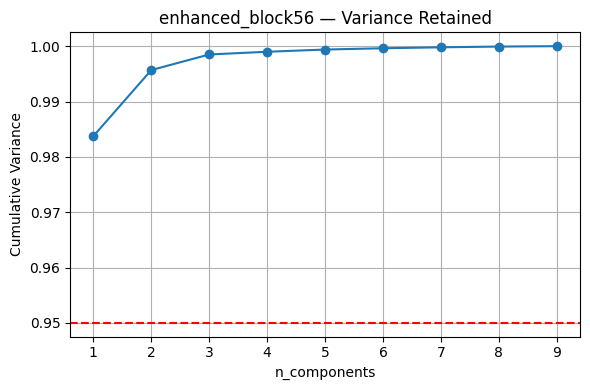

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 57: ['Phase_4_div_Phase_5', 'Phase_5_div_Phase_4']


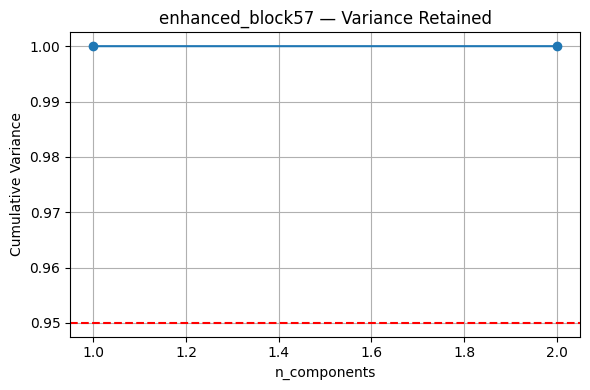

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 58: ['Phase_5_div_Phase_6', 'Phase_6_div_Phase_5']


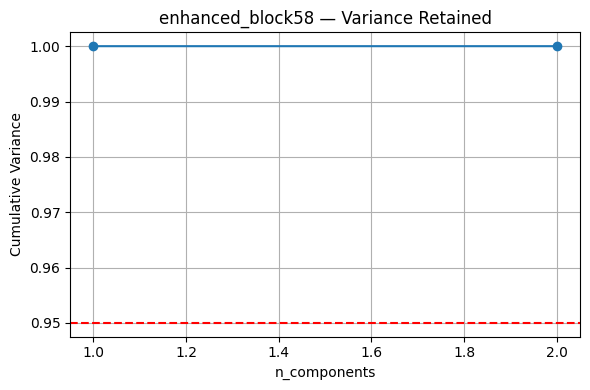

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 59: ['Phase_5_div_Phase_7', 'Phase_7_div_Phase_5']


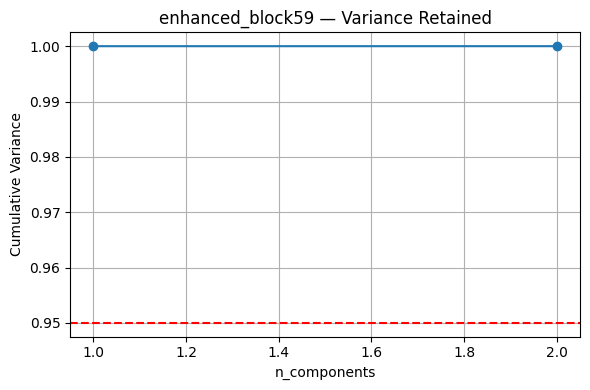

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 60: ['Phase_5_div_Phase_8', 'Phase_8_div_Phase_5']


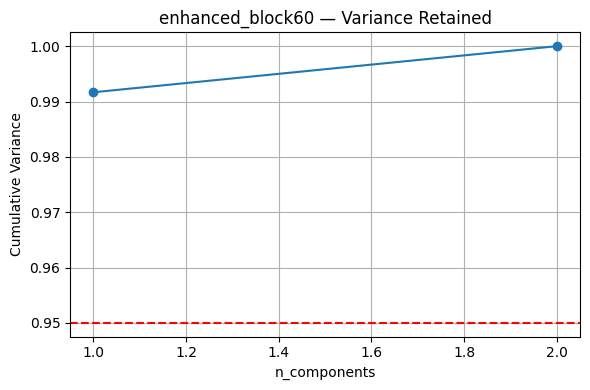

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 61: ['Phase_6_div_Phase_8', 'Phase_8_div_Phase_6']


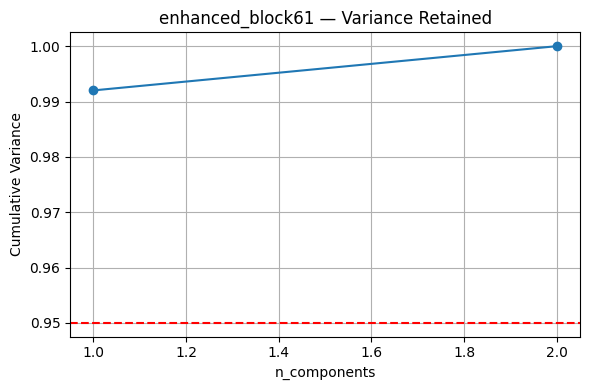

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



🔧 Block 62: ['Chem_7_div_Phase_13', 'Phase_6_div_Phase_13']


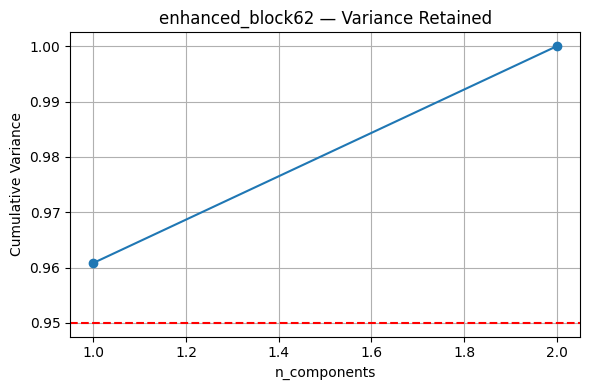


✅ enhanced — Final shapes: (5950, 190) (train), (1050, 190) (val), (1224, 190) (test)
✅ Added PCA-transformed version as 'enhanced_pca'


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [ ]:
for key, data in list(datasets_loaded.items()):
    print(f"\n🔁 Trying PCA on: {key}")
    X_train_pca, X_val_pca, X_test_pca = apply_pca_blocks_to_dataset(
        data['X_train'], data['X_val'], data['X_test'], name=key
    )

    # Only add if PCA changed dimensionality
    if X_train_pca is not None and X_train_pca.shape[1] != data['X_train'].shape[1]:
        pca_key = f"{key}_pca"
        datasets_loaded[pca_key] = {
            'X_train': X_train_pca,
            'X_val': X_val_pca,
            'X_test': X_test_pca,
            'y_train': data['y_train'],
            'y_val': data['y_val'],
            'y_test': data['y_test']
        }
        print(f"✅ Added PCA-transformed version as '{pca_key}'")
    else:
        print(f"⏭️ Skipped PCA for {key} (no dimensionality change)")



### 🔁 Autoencoder Training and Dataset Compression

This block trains an Autoencoder on each dataset version to compress input features into a lower-dimensional latent space:

- **Architecture**: Dynamically adjusts encoder/decoder size based on input dimensionality.
- **Training**: 100-epoch optimization using MSE loss and Adam optimizer.
- **Metrics**: Computes R² and RRMSE on train/val/test splits to assess reconstruction quality.
- **Visualization**: Plots loss curves and UMAP projections comparing original vs. reconstructed features.
- **Output**: Adds new dataset versions (e.g., `*_ae`) that include categorical features and the Autoencoder’s latent representation.

This helps evaluate how well the Autoencoder captures data structure, enabling compact yet informative representations for downstream modeling.




🔧 Autoencoding: raw
📊 Input features: 45
📐 Architecture → Encoder: 45 → 64 → 32 → Decoder: 32 → 64 → 45


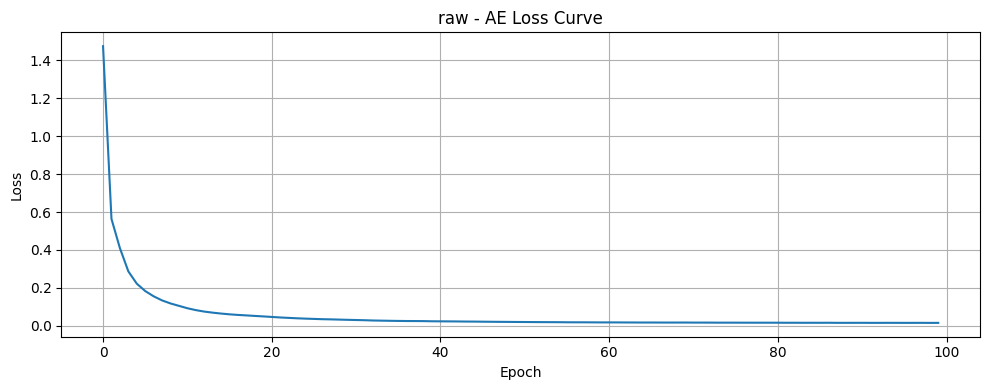

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


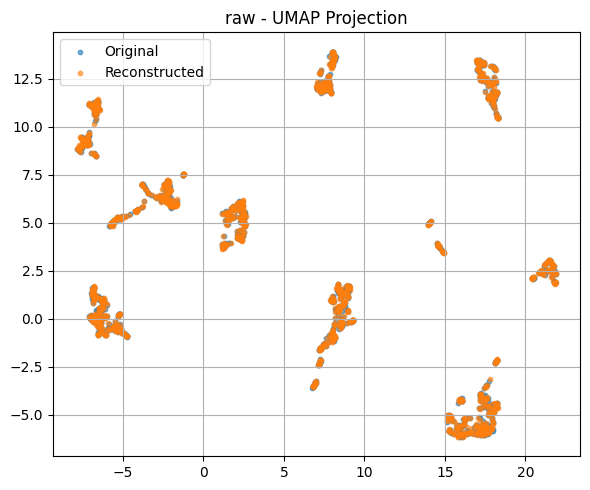

📊 R²: Train = 0.9844, Val = 0.9637, Test = 0.9824
📉 RRMSE: Train = 0.4728, Val = 0.4595, Test = 0.4996
✅ Added AE-transformed version as 'raw_ae'

🔧 Autoencoding: enhanced
📊 Input features: 461
📐 Architecture → Encoder: 461 → 512 → 256 → Decoder: 256 → 512 → 461


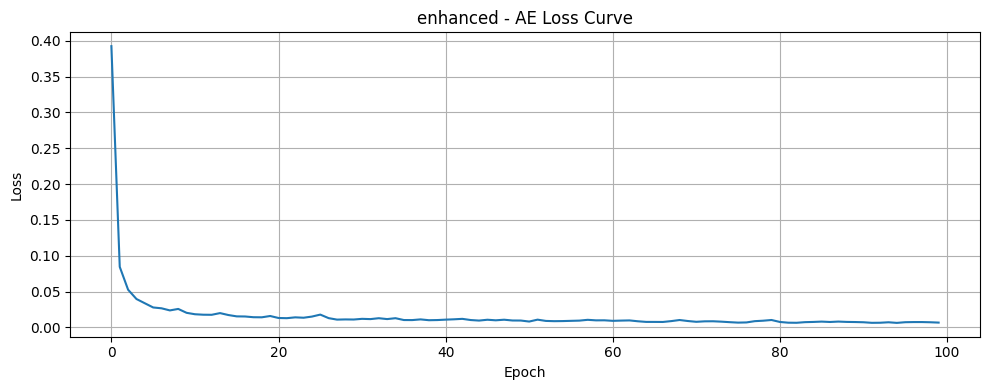

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


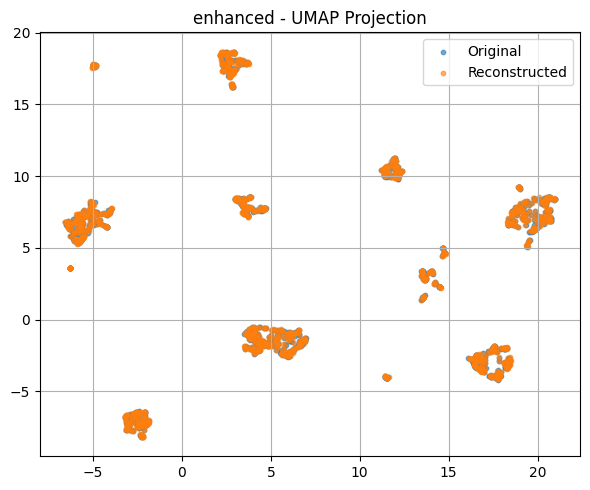

📊 R²: Train = -27076803220938301175234560.0000, Val = 0.9909, Test = 0.9828
📉 RRMSE: Train = 0.4471, Val = 0.5271, Test = 0.4513
✅ Added AE-transformed version as 'enhanced_ae'

🔧 Autoencoding: raw_pca
📊 Input features: 40
📐 Architecture → Encoder: 40 → 64 → 32 → Decoder: 32 → 64 → 40


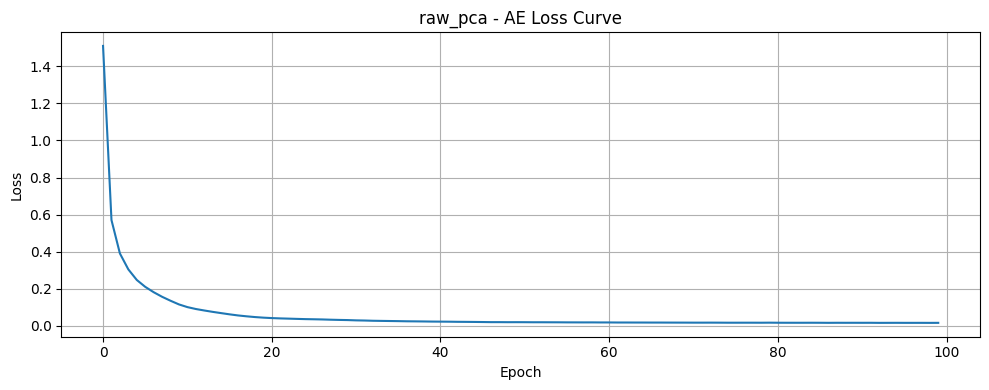

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


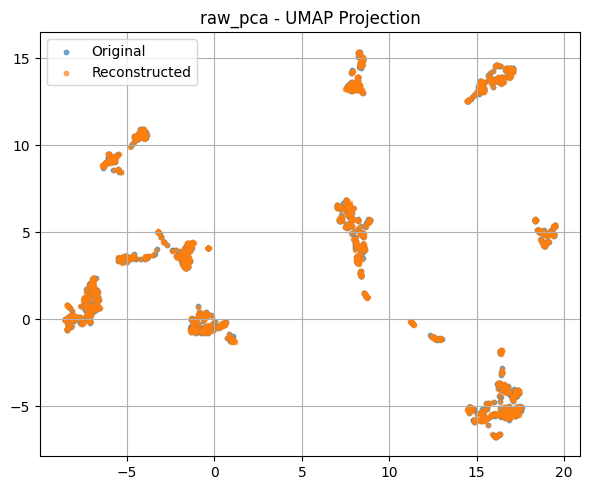

📊 R²: Train = 0.9750, Val = 0.9566, Test = 0.9720
📉 RRMSE: Train = 0.4413, Val = 0.4398, Test = 0.4690
✅ Added AE-transformed version as 'raw_pca_ae'

🔧 Autoencoding: enhanced_pca
📊 Input features: 177
📐 Architecture → Encoder: 177 → 256 → 128 → Decoder: 128 → 256 → 177


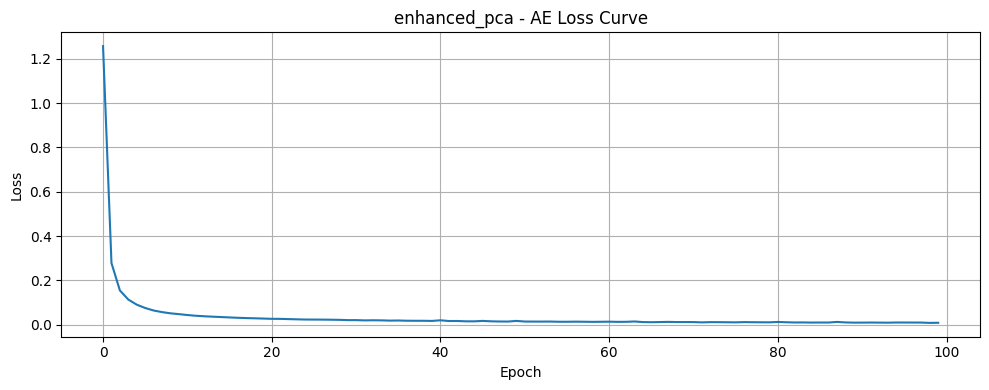

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


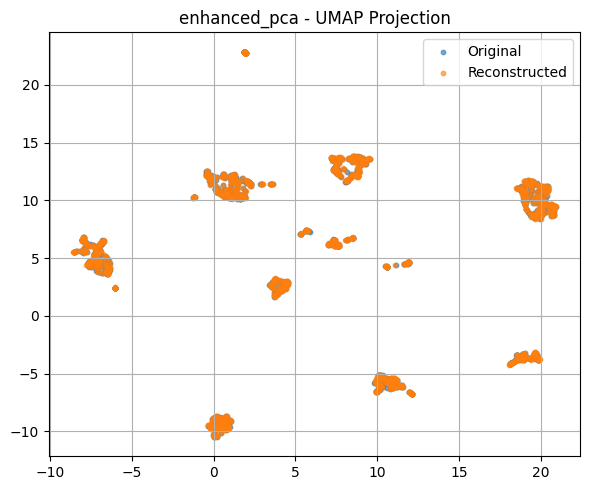

📊 R²: Train = -29584771089963204311252992.0000, Val = 0.9850, Test = 0.9782
📉 RRMSE: Train = 0.8673, Val = 0.9793, Test = 0.8466
✅ Added AE-transformed version as 'enhanced_pca_ae'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from scipy.spatial import distance
import statsmodels.api as sm
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# ⚙️ Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoder_layers, latent_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        enc = []
        prev = input_dim
        for h in encoder_layers:
            enc.append(nn.Linear(prev, h))
            enc.append(nn.ReLU())
            prev = h
        enc.append(nn.Linear(prev, latent_dim))
        self.encoder = nn.Sequential(*enc)

        # Decoder (mirror)
        dec = []
        prev = latent_dim
        for h in reversed(encoder_layers):
            dec.append(nn.Linear(prev, h))
            dec.append(nn.ReLU())
            prev = h
        dec.append(nn.Linear(prev, input_dim))
        self.decoder = nn.Sequential(*dec)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# 📐 Metrics
def compute_rrmse(X_true, X_recon):
    denom = np.abs(np.mean(X_true))
    return np.sqrt(np.mean((X_true - X_recon) ** 2)) / denom if denom != 0 else np.inf

def compute_r2(X_true, X_recon):
    return r2_score(X_true, X_recon, multioutput='uniform_average')

def plot_umap_reconstruction(X_true, X_recon, label):
    reducer = umap.UMAP(random_state=42)
    emb = reducer.fit_transform(np.vstack([X_true, X_recon]))
    n = len(X_true)
    plt.figure(figsize=(6, 5))
    plt.scatter(emb[:n, 0], emb[:n, 1], s=10, label='Original', alpha=0.6)
    plt.scatter(emb[n:, 0], emb[n:, 1], s=10, label='Reconstructed', alpha=0.6)
    plt.title(f'{label} - UMAP Projection')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 🔁 Autoencode every dataset safely
ae_results_dict = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

original_keys = list(datasets_loaded.keys())

for key in original_keys:
    data = datasets_loaded[key]
    print(f"\n🔧 Autoencoding: {key}")

    def filter_features(X):
        return X[[col for col in X.columns if not (col.startswith("Type_") or col.startswith("Process_"))]]

    def extract_cat_features(X):
        return X[[col for col in X.columns if col.startswith("Type_") or col.startswith("Process_")]]

    X_train = filter_features(data['X_train'])
    X_val   = filter_features(data['X_val'])
    X_test  = filter_features(data['X_test'])

    X_train_cat = extract_cat_features(data['X_train'])
    X_val_cat   = extract_cat_features(data['X_val'])
    X_test_cat  = extract_cat_features(data['X_test'])

    feature_names = list(X_train.columns)


    if X_train.shape[1] == 0:
        print(f"⏭️ Skipping {key} (no usable features after filtering)")
        continue

    input_dim = X_train.shape[1]
    if input_dim < 10:
        print(f"⏭️ Skipping {key} (too few features for AE)")
        continue

    if input_dim < 64:
        latent_dim = 32
    elif input_dim < 128:
        latent_dim = 64
    elif input_dim < 256:
        latent_dim = 128
    elif input_dim < 512:
        latent_dim = 256
    else:
        latent_dim = input_dim // 2

    middle_dim = 2 ** math.ceil(math.log2(max(input_dim, latent_dim)))
    encoder_layers = [middle_dim] if middle_dim > latent_dim else []
    decoder_layers = list(reversed(encoder_layers))

    print(f"📊 Input features: {input_dim}")
    print(f"📐 Architecture → Encoder: {input_dim} → {' → '.join(map(str, encoder_layers))} → {latent_dim} → Decoder: {latent_dim} → {' → '.join(map(str, decoder_layers))} → {input_dim}")

    ae = Autoencoder(input_dim, encoder_layers, latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae.parameters(), lr=1e-3)

    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    X_val_tensor   = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

    loss_curve = []
    for epoch in range(100):
        ae.train()
        epoch_loss = 0
        for xb, in train_loader:
            optimizer.zero_grad()
            recon = ae(xb)
            loss = criterion(recon, xb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        loss_curve.append(epoch_loss / len(X_train))

    ae.eval()
    with torch.no_grad():
        X_train_encoded = ae.encoder(X_train_tensor).cpu().numpy()
        X_val_encoded   = ae.encoder(X_val_tensor).cpu().numpy()
        X_test_encoded  = ae.encoder(X_test_tensor).cpu().numpy()

        X_train_recon = ae(X_train_tensor).cpu().numpy()
        X_val_recon   = ae(X_val_tensor).cpu().numpy()
        X_test_recon  = ae(X_test_tensor).cpu().numpy()

    # Compute metrics
    train_r2    = compute_r2(X_train.values, X_train_recon)
    val_r2      = compute_r2(X_val.values, X_val_recon)
    test_r2     = compute_r2(X_test.values, X_test_recon)

    train_rrmse = compute_rrmse(X_train.values, X_train_recon)
    val_rrmse   = compute_rrmse(X_val.values, X_val_recon)
    test_rrmse  = compute_rrmse(X_test.values, X_test_recon)

    # Store results + model info
    ae_results_dict[key] = {
        'latent_dim': latent_dim,
        'encoder_layers': encoder_layers,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'test_r2': test_r2,
        'train_rrmse': train_rrmse,
        'val_rrmse': val_rrmse,
        'test_rrmse': test_rrmse,
        'loss_curve': loss_curve,
        'model_info': {
            'state_dict': ae.state_dict(),
            'input_dim': input_dim,
            'latent_dim': latent_dim,
            'encoder_layers': encoder_layers,
            'feature_names': feature_names
        }
    }

    # Plot loss + diagnostics
    plt.figure(figsize=(10, 4))
    plt.plot(loss_curve)
    plt.title(f"{key} - AE Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plot_umap_reconstruction(X_test.values, X_test_recon, key)

    print(f"📊 R²: Train = {train_r2:.4f}, Val = {val_r2:.4f}, Test = {test_r2:.4f}")
    print(f"📉 RRMSE: Train = {train_rrmse:.4f}, Val = {val_rrmse:.4f}, Test = {test_rrmse:.4f}")

    # Combine categorical features FIRST, then AE-transformed features
    X_train_final = pd.concat([
        X_train_cat,
        pd.DataFrame(X_train_encoded, index=data['X_train'].index,
                    columns=[f"ae_{i}" for i in range(X_train_encoded.shape[1])])
    ], axis=1)

    X_val_final = pd.concat([
        X_val_cat,
        pd.DataFrame(X_val_encoded, index=data['X_val'].index,
                    columns=[f"ae_{i}" for i in range(X_val_encoded.shape[1])])
    ], axis=1)

    X_test_final = pd.concat([
        X_test_cat,
        pd.DataFrame(X_test_encoded, index=data['X_test'].index,
                    columns=[f"ae_{i}" for i in range(X_test_encoded.shape[1])])
    ], axis=1)

    # Save AE-transformed dataset
    ae_key = f"{key}_ae"
    datasets_loaded[ae_key] = {
        'X_train': X_train_final,
        'X_val': X_val_final,
        'X_test': X_test_final,
        'y_train': data['y_train'],
        'y_val': data['y_val'],
        'y_test': data['y_test']
    }


    print(f"✅ Added AE-transformed version as '{ae_key}'")


### 📦 View Available Dataset Variants

This step lists all the current versions of the datasets stored in memory, including:

- Raw versions
- PCA-transformed datasets
- Autoencoder-compressed datasets
- Combined PCA + AE versions (if any)

This overview helps track which datasets are available for modeling and ensures transformations have been applied successfully.


In [ ]:
print("📦 Available dataset keys:")
for key in datasets_loaded.keys():
    print(f"  - {key}")


📦 Available dataset keys:
  - raw
  - enhanced
  - raw_pca
  - enhanced_pca
  - raw_ae
  - enhanced_ae
  - raw_pca_ae
  - enhanced_pca_ae


### 🧠 Train Complex MLP Models on All Datasets

In this section, we train a deeper Multi-Layer Perceptron (MLP) for each dataset variant, adapting its architecture based on input dimensionality. The training includes:

- **Custom architecture scaling**: The network depth and width adjust to the dataset's feature count.
- **Early stopping**: Stops training if no improvement is seen in validation RRMSE over a patience window.
- **Performance tracking**: Loss, R², and RRMSE are tracked for training, validation, and test sets.
- **Model saving**: Best-performing model and metadata are stored for each dataset version.

This comprehensive loop helps compare how each data processing technique (raw, PCA, AE, etc.) affects model performance across metrics and dataset splits.




🧠 Training PyTorch MLP on: raw
  Epoch   50 | Val R²: 0.875, Val RRMS: 0.172
  Epoch  100 | Val R²: 0.875, Val RRMS: 0.171
  Epoch  150 | Val R²: 0.871, Val RRMS: 0.174
  Epoch  200 | Val R²: 0.880, Val RRMS: 0.168
  Epoch  250 | Val R²: 0.884, Val RRMS: 0.165
  Epoch  300 | Val R²: 0.880, Val RRMS: 0.168
  Epoch  350 | Val R²: 0.875, Val RRMS: 0.171
  Epoch  400 | Val R²: 0.876, Val RRMS: 0.171
  Epoch  450 | Val R²: 0.878, Val RRMS: 0.169
  Epoch  500 | Val R²: 0.876, Val RRMS: 0.171
  Epoch  550 | Val R²: 0.882, Val RRMS: 0.167
  Epoch  600 | Val R²: 0.877, Val RRMS: 0.170
  Epoch  650 | Val R²: 0.881, Val RRMS: 0.167
  Epoch  700 | Val R²: 0.877, Val RRMS: 0.170
  Epoch  750 | Val R²: 0.872, Val RRMS: 0.173
  Epoch  800 | Val R²: 0.882, Val RRMS: 0.166
  Epoch  850 | Val R²: 0.886, Val RRMS: 0.163
  Epoch  900 | Val R²: 0.887, Val RRMS: 0.163
  Epoch  950 | Val R²: 0.885, Val RRMS: 0.164
  Epoch 1000 | Val R²: 0.884, Val RRMS: 0.165


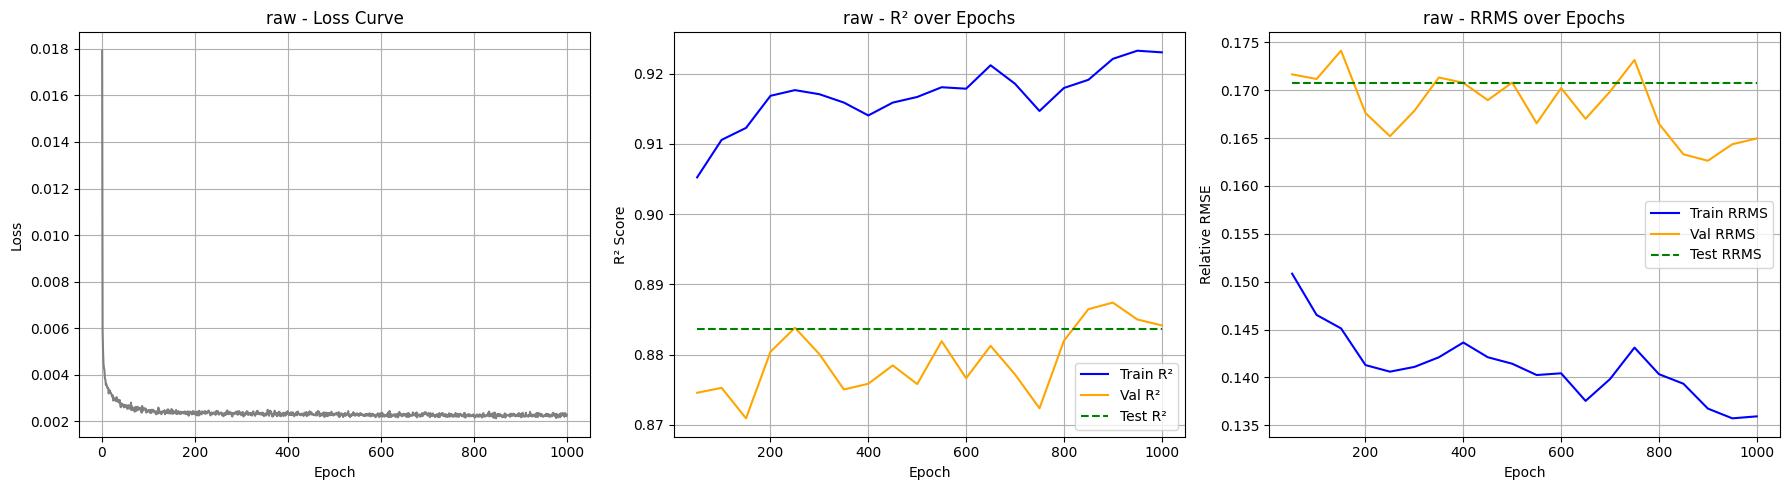

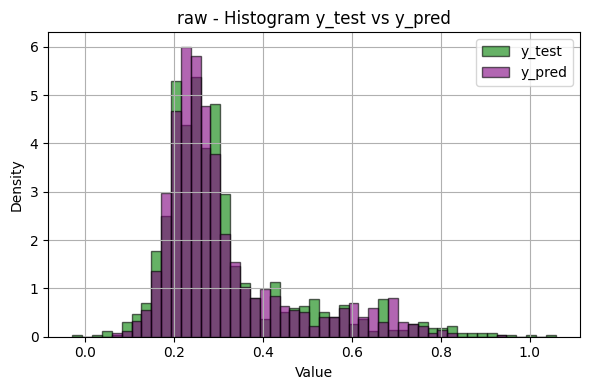


🧠 Training PyTorch MLP on: enhanced
  Epoch   50 | Val R²: 0.919, Val RRMS: 0.141
  Epoch  100 | Val R²: 0.921, Val RRMS: 0.138
  Epoch  150 | Val R²: 0.919, Val RRMS: 0.140
  Epoch  200 | Val R²: 0.899, Val RRMS: 0.157
  Epoch  250 | Val R²: 0.918, Val RRMS: 0.141
  Epoch  300 | Val R²: 0.924, Val RRMS: 0.136
  Epoch  350 | Val R²: 0.917, Val RRMS: 0.142
  Epoch  400 | Val R²: 0.886, Val RRMS: 0.166
  Epoch  450 | Val R²: 0.914, Val RRMS: 0.144
  Epoch  500 | Val R²: 0.916, Val RRMS: 0.143
  Epoch  550 | Val R²: 0.926, Val RRMS: 0.134
  Epoch  600 | Val R²: 0.926, Val RRMS: 0.134
  Epoch  650 | Val R²: 0.907, Val RRMS: 0.150
  Epoch  700 | Val R²: 0.923, Val RRMS: 0.136
  Epoch  750 | Val R²: 0.921, Val RRMS: 0.139
  Epoch  800 | Val R²: 0.925, Val RRMS: 0.135
  Epoch  850 | Val R²: 0.924, Val RRMS: 0.136
  Epoch  900 | Val R²: 0.912, Val RRMS: 0.146
  Epoch  950 | Val R²: 0.918, Val RRMS: 0.141
  Epoch 1000 | Val R²: 0.923, Val RRMS: 0.137


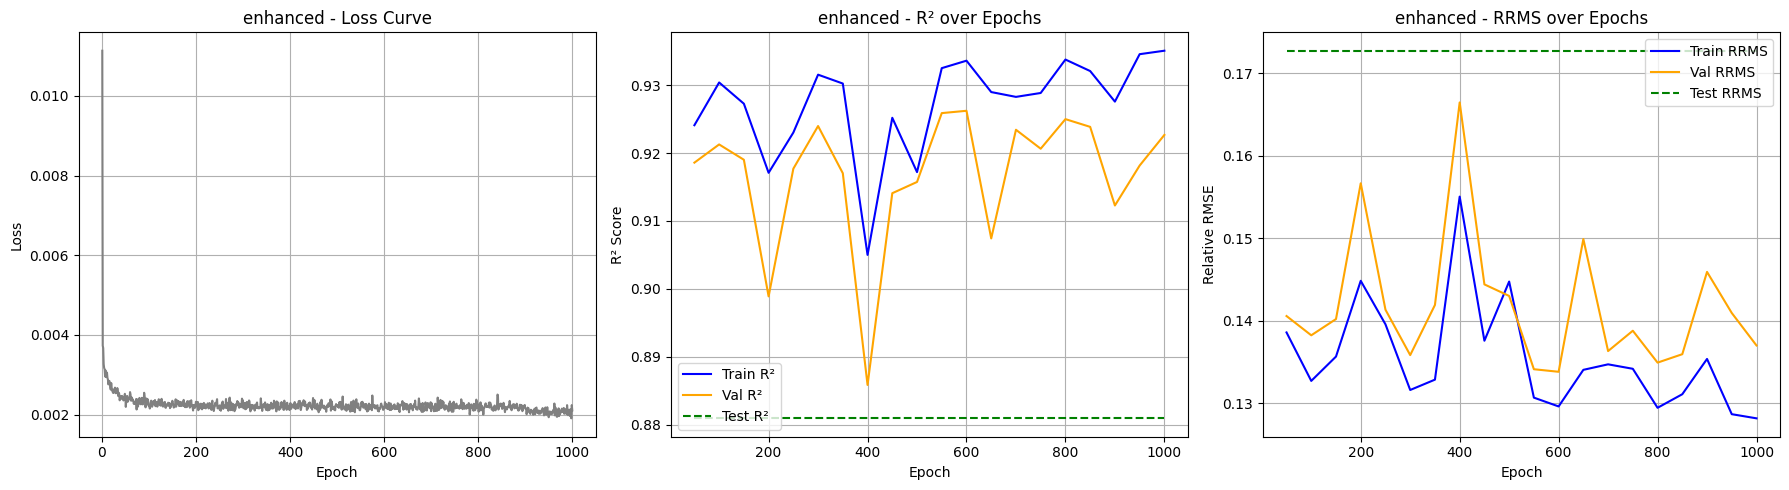

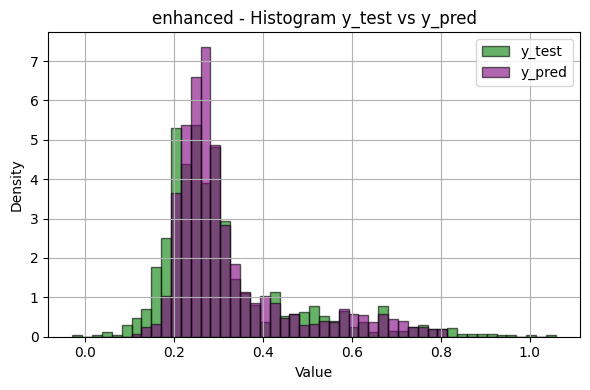


🧠 Training PyTorch MLP on: raw_pca
  Epoch   50 | Val R²: 0.874, Val RRMS: 0.172
  Epoch  100 | Val R²: 0.881, Val RRMS: 0.167
  Epoch  150 | Val R²: 0.876, Val RRMS: 0.170
  Epoch  200 | Val R²: 0.879, Val RRMS: 0.168
  Epoch  250 | Val R²: 0.879, Val RRMS: 0.169
  Epoch  300 | Val R²: 0.879, Val RRMS: 0.168
  Epoch  350 | Val R²: 0.886, Val RRMS: 0.164
  Epoch  400 | Val R²: 0.860, Val RRMS: 0.181
  Epoch  450 | Val R²: 0.877, Val RRMS: 0.170
  Epoch  500 | Val R²: 0.881, Val RRMS: 0.167
  Epoch  550 | Val R²: 0.879, Val RRMS: 0.169
  Epoch  600 | Val R²: 0.887, Val RRMS: 0.163
  Epoch  650 | Val R²: 0.886, Val RRMS: 0.164
  Epoch  700 | Val R²: 0.883, Val RRMS: 0.166
  Epoch  750 | Val R²: 0.879, Val RRMS: 0.168
  Epoch  800 | Val R²: 0.880, Val RRMS: 0.168
  Epoch  850 | Val R²: 0.886, Val RRMS: 0.164
  Epoch  900 | Val R²: 0.885, Val RRMS: 0.164
  Epoch  950 | Val R²: 0.884, Val RRMS: 0.165
  Epoch 1000 | Val R²: 0.881, Val RRMS: 0.167


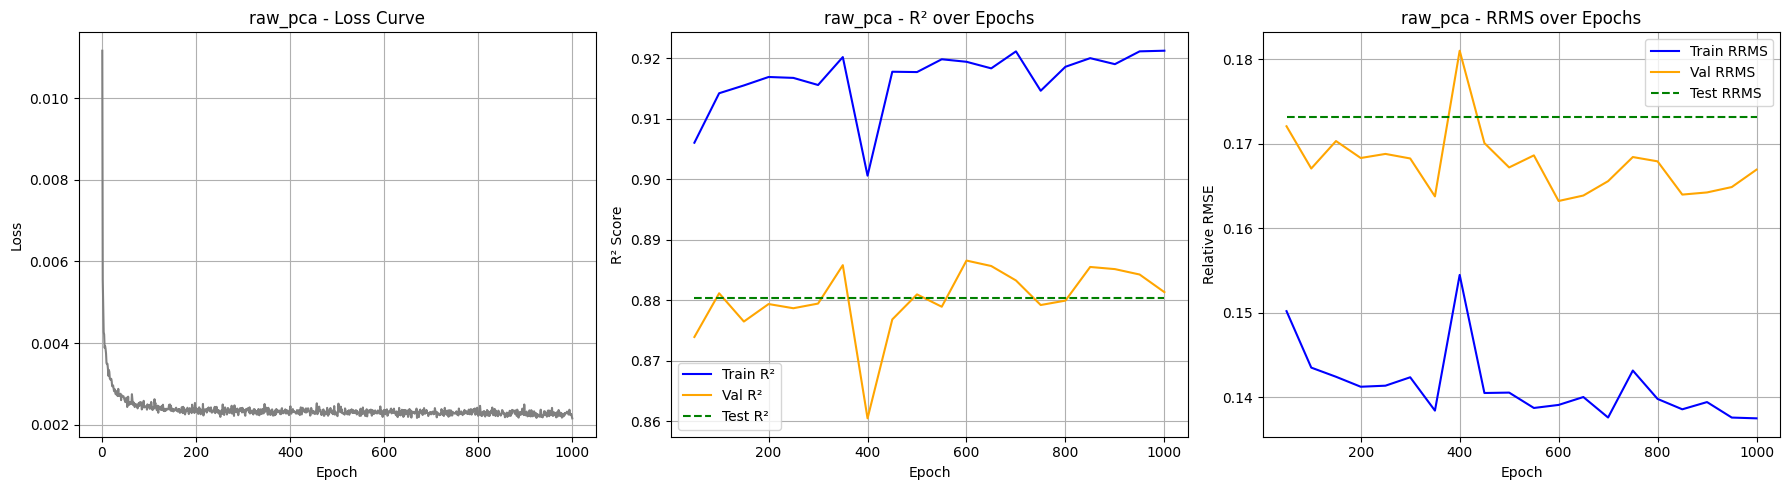

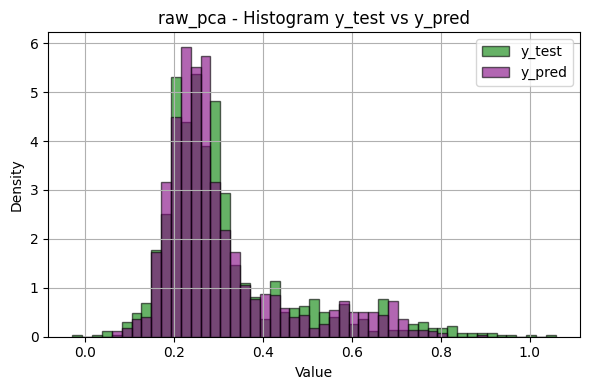


🧠 Training PyTorch MLP on: enhanced_pca
  Epoch   50 | Val R²: 0.921, Val RRMS: 0.139
  Epoch  100 | Val R²: 0.926, Val RRMS: 0.134
  Epoch  150 | Val R²: 0.913, Val RRMS: 0.146
  Epoch  200 | Val R²: 0.921, Val RRMS: 0.139
  Epoch  250 | Val R²: 0.927, Val RRMS: 0.133
  Epoch  300 | Val R²: 0.929, Val RRMS: 0.132
  Epoch  350 | Val R²: 0.928, Val RRMS: 0.132
  Epoch  400 | Val R²: 0.923, Val RRMS: 0.137
  Epoch  450 | Val R²: 0.920, Val RRMS: 0.139
  Epoch  500 | Val R²: 0.919, Val RRMS: 0.140
  Epoch  550 | Val R²: 0.923, Val RRMS: 0.137
  Epoch  600 | Val R²: 0.922, Val RRMS: 0.137
  Epoch  650 | Val R²: 0.923, Val RRMS: 0.137
  Epoch  700 | Val R²: 0.928, Val RRMS: 0.132
  Epoch  750 | Val R²: 0.923, Val RRMS: 0.137
  Epoch  800 | Val R²: 0.928, Val RRMS: 0.133
  Epoch  850 | Val R²: 0.923, Val RRMS: 0.137
  Epoch  900 | Val R²: 0.920, Val RRMS: 0.139
  Epoch  950 | Val R²: 0.928, Val RRMS: 0.132
  Epoch 1000 | Val R²: 0.923, Val RRMS: 0.137


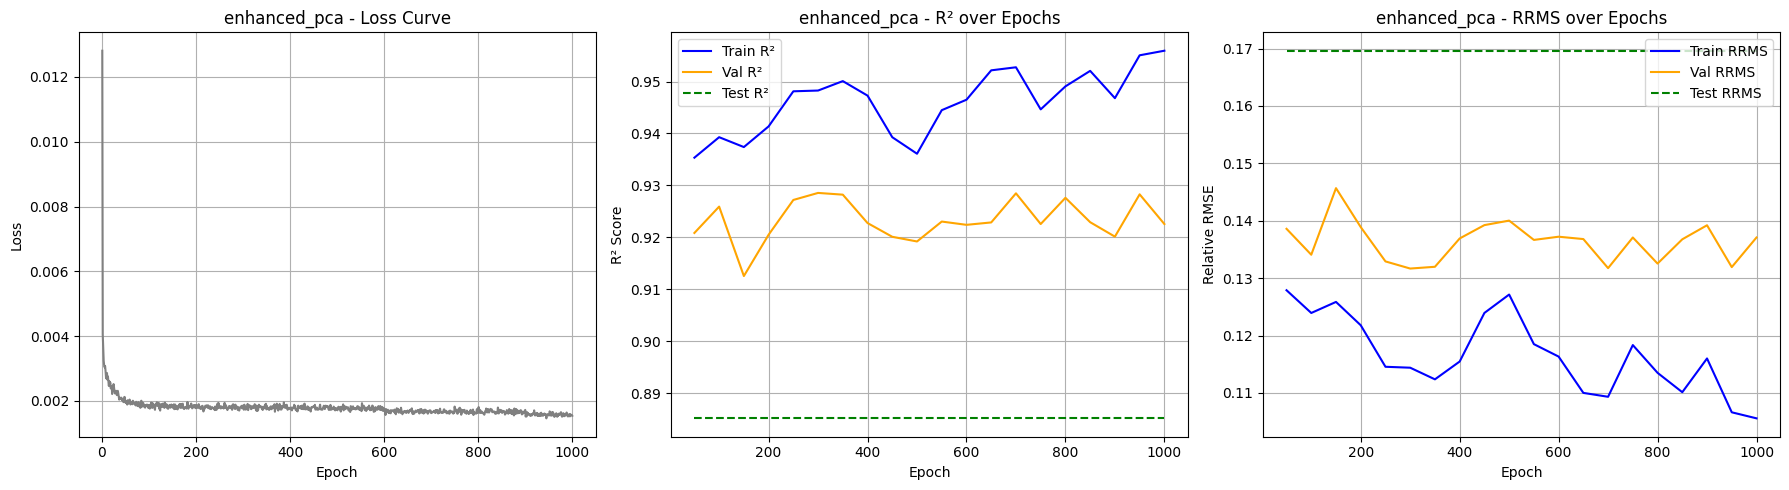

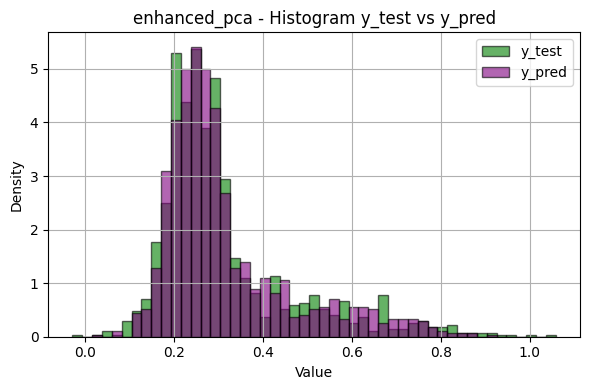


🧠 Training PyTorch MLP on: raw_ae
  Epoch   50 | Val R²: 0.871, Val RRMS: 0.174
  Epoch  100 | Val R²: 0.872, Val RRMS: 0.174
  Epoch  150 | Val R²: 0.874, Val RRMS: 0.172
  Epoch  200 | Val R²: 0.877, Val RRMS: 0.170
  Epoch  250 | Val R²: 0.884, Val RRMS: 0.165
  Epoch  300 | Val R²: 0.868, Val RRMS: 0.176
  Epoch  350 | Val R²: 0.879, Val RRMS: 0.168
  Epoch  400 | Val R²: 0.874, Val RRMS: 0.172
  Epoch  450 | Val R²: 0.874, Val RRMS: 0.172
  Epoch  500 | Val R²: 0.872, Val RRMS: 0.173
  Epoch  550 | Val R²: 0.888, Val RRMS: 0.162
  Epoch  600 | Val R²: 0.866, Val RRMS: 0.178
  Epoch  650 | Val R²: 0.888, Val RRMS: 0.162
  Epoch  700 | Val R²: 0.886, Val RRMS: 0.164
  Epoch  750 | Val R²: 0.884, Val RRMS: 0.165
  Epoch  800 | Val R²: 0.887, Val RRMS: 0.163
  Epoch  850 | Val R²: 0.884, Val RRMS: 0.165
  Epoch  900 | Val R²: 0.873, Val RRMS: 0.173
  Epoch  950 | Val R²: 0.885, Val RRMS: 0.164
  Epoch 1000 | Val R²: 0.883, Val RRMS: 0.165


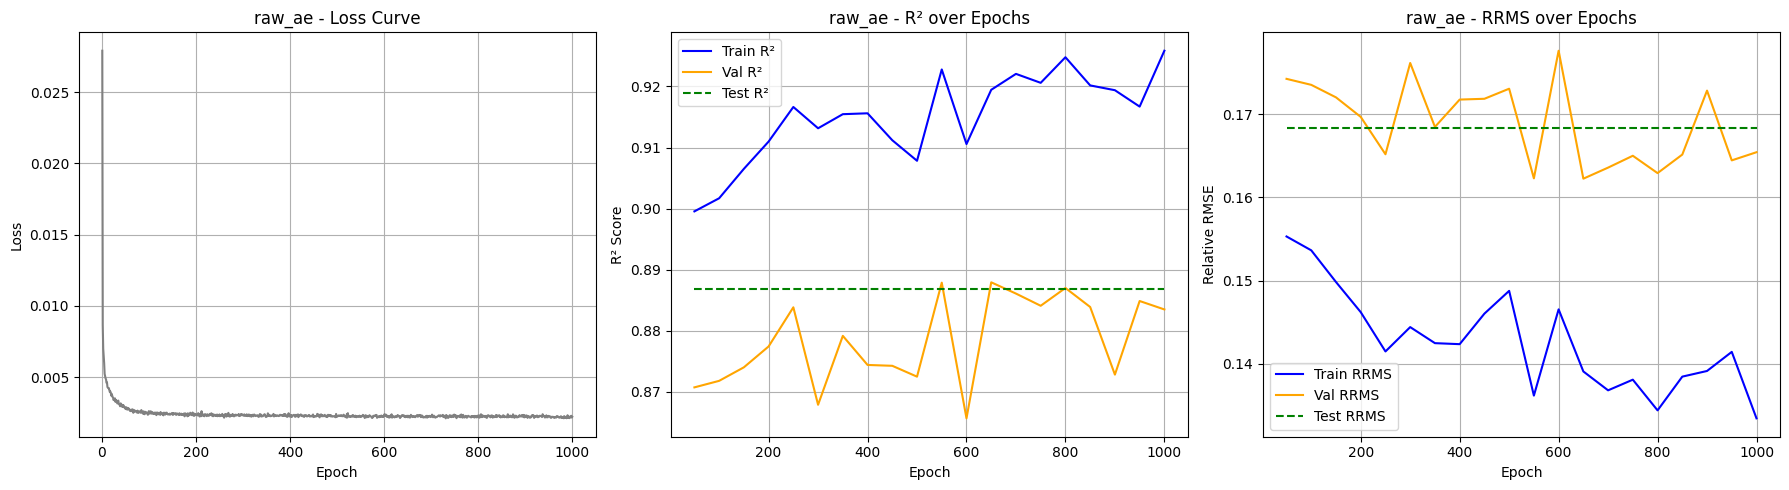

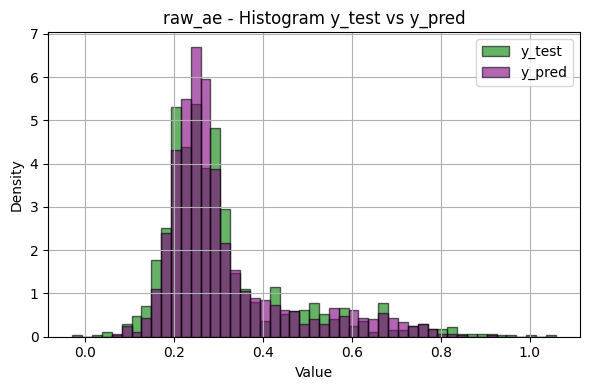


🧠 Training PyTorch MLP on: enhanced_ae
  Epoch   50 | Val R²: 0.927, Val RRMS: 0.133
  Epoch  100 | Val R²: 0.924, Val RRMS: 0.136
  Epoch  150 | Val R²: 0.933, Val RRMS: 0.128
  Epoch  200 | Val R²: 0.929, Val RRMS: 0.131
  Epoch  250 | Val R²: 0.930, Val RRMS: 0.131
  Epoch  300 | Val R²: 0.932, Val RRMS: 0.128
  Epoch  350 | Val R²: 0.926, Val RRMS: 0.134
  Epoch  400 | Val R²: 0.923, Val RRMS: 0.136
  Epoch  450 | Val R²: 0.926, Val RRMS: 0.134
  Epoch  500 | Val R²: 0.918, Val RRMS: 0.141
  Epoch  550 | Val R²: 0.924, Val RRMS: 0.135
  Epoch  600 | Val R²: 0.929, Val RRMS: 0.131
  Epoch  650 | Val R²: 0.921, Val RRMS: 0.138
  Epoch  700 | Val R²: 0.928, Val RRMS: 0.132
  Epoch  750 | Val R²: 0.926, Val RRMS: 0.134
  Epoch  800 | Val R²: 0.931, Val RRMS: 0.129
  Epoch  850 | Val R²: 0.929, Val RRMS: 0.131
  Epoch  900 | Val R²: 0.927, Val RRMS: 0.133
  Epoch  950 | Val R²: 0.932, Val RRMS: 0.129
  Epoch 1000 | Val R²: 0.926, Val RRMS: 0.134


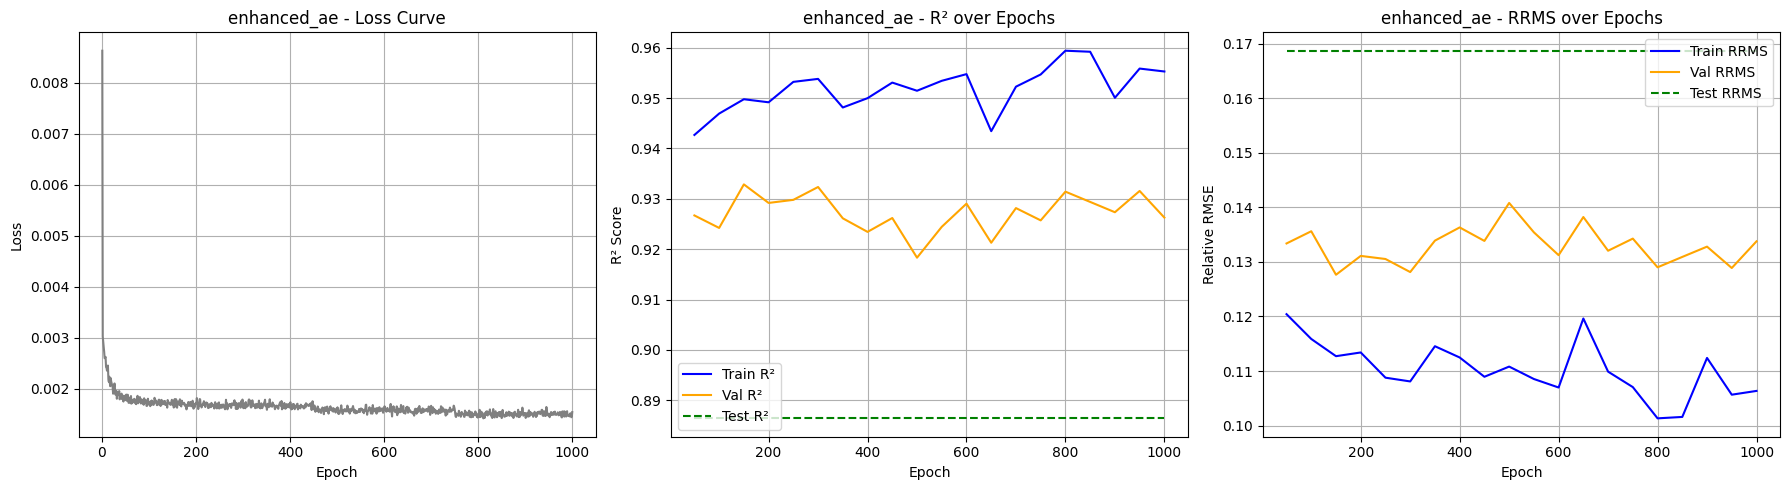

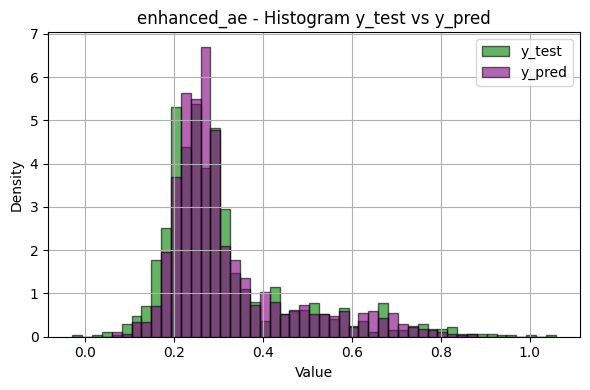


🧠 Training PyTorch MLP on: raw_pca_ae
  Epoch   50 | Val R²: 0.874, Val RRMS: 0.172
  Epoch  100 | Val R²: 0.848, Val RRMS: 0.189
  Epoch  150 | Val R²: 0.850, Val RRMS: 0.188
  Epoch  200 | Val R²: 0.879, Val RRMS: 0.169
  Epoch  250 | Val R²: 0.877, Val RRMS: 0.170
  Epoch  300 | Val R²: 0.881, Val RRMS: 0.167
  Epoch  350 | Val R²: 0.875, Val RRMS: 0.171
  Epoch  400 | Val R²: 0.877, Val RRMS: 0.170
  Epoch  450 | Val R²: 0.874, Val RRMS: 0.172
  Epoch  500 | Val R²: 0.866, Val RRMS: 0.177
  Epoch  550 | Val R²: 0.846, Val RRMS: 0.190
  Epoch  600 | Val R²: 0.878, Val RRMS: 0.170
  Epoch  650 | Val R²: 0.880, Val RRMS: 0.168
  Epoch  700 | Val R²: 0.878, Val RRMS: 0.169
  Epoch  750 | Val R²: 0.880, Val RRMS: 0.168
  Epoch  800 | Val R²: 0.881, Val RRMS: 0.167
  Epoch  850 | Val R²: 0.879, Val RRMS: 0.168
  Epoch  900 | Val R²: 0.875, Val RRMS: 0.171
  Epoch  950 | Val R²: 0.881, Val RRMS: 0.167
  Epoch 1000 | Val R²: 0.884, Val RRMS: 0.165


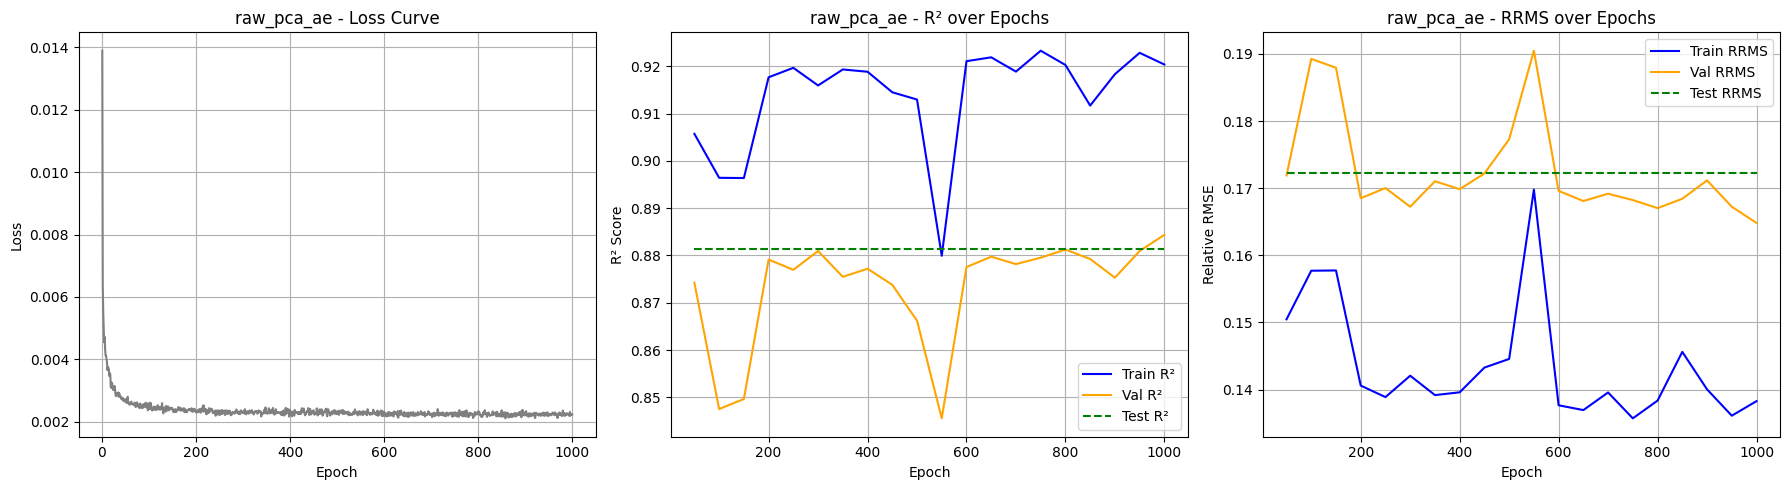

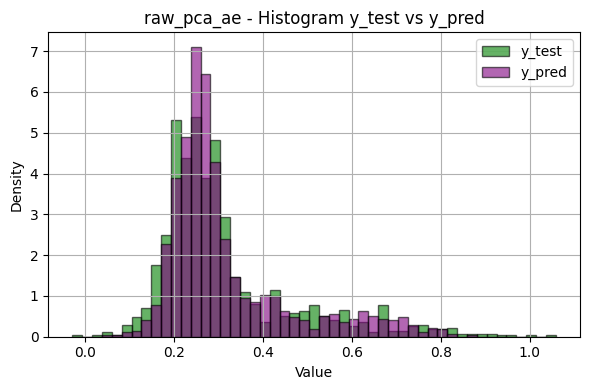


🧠 Training PyTorch MLP on: enhanced_pca_ae
  Epoch   50 | Val R²: 0.927, Val RRMS: 0.133
  Epoch  100 | Val R²: 0.921, Val RRMS: 0.138
  Epoch  150 | Val R²: 0.926, Val RRMS: 0.134
  Epoch  200 | Val R²: 0.928, Val RRMS: 0.132
  Epoch  250 | Val R²: 0.910, Val RRMS: 0.148
  Epoch  300 | Val R²: 0.912, Val RRMS: 0.146
  Epoch  350 | Val R²: 0.928, Val RRMS: 0.132
  Epoch  400 | Val R²: 0.925, Val RRMS: 0.135
  Epoch  450 | Val R²: 0.929, Val RRMS: 0.131
  Epoch  500 | Val R²: 0.930, Val RRMS: 0.131
  Epoch  550 | Val R²: 0.931, Val RRMS: 0.130
  Epoch  600 | Val R²: 0.925, Val RRMS: 0.135
  Epoch  650 | Val R²: 0.924, Val RRMS: 0.136
  Epoch  700 | Val R²: 0.918, Val RRMS: 0.141
  Epoch  750 | Val R²: 0.927, Val RRMS: 0.133
  Epoch  800 | Val R²: 0.926, Val RRMS: 0.134
  Epoch  850 | Val R²: 0.923, Val RRMS: 0.137
  Epoch  900 | Val R²: 0.930, Val RRMS: 0.130
  Epoch  950 | Val R²: 0.928, Val RRMS: 0.133
  Epoch 1000 | Val R²: 0.926, Val RRMS: 0.134


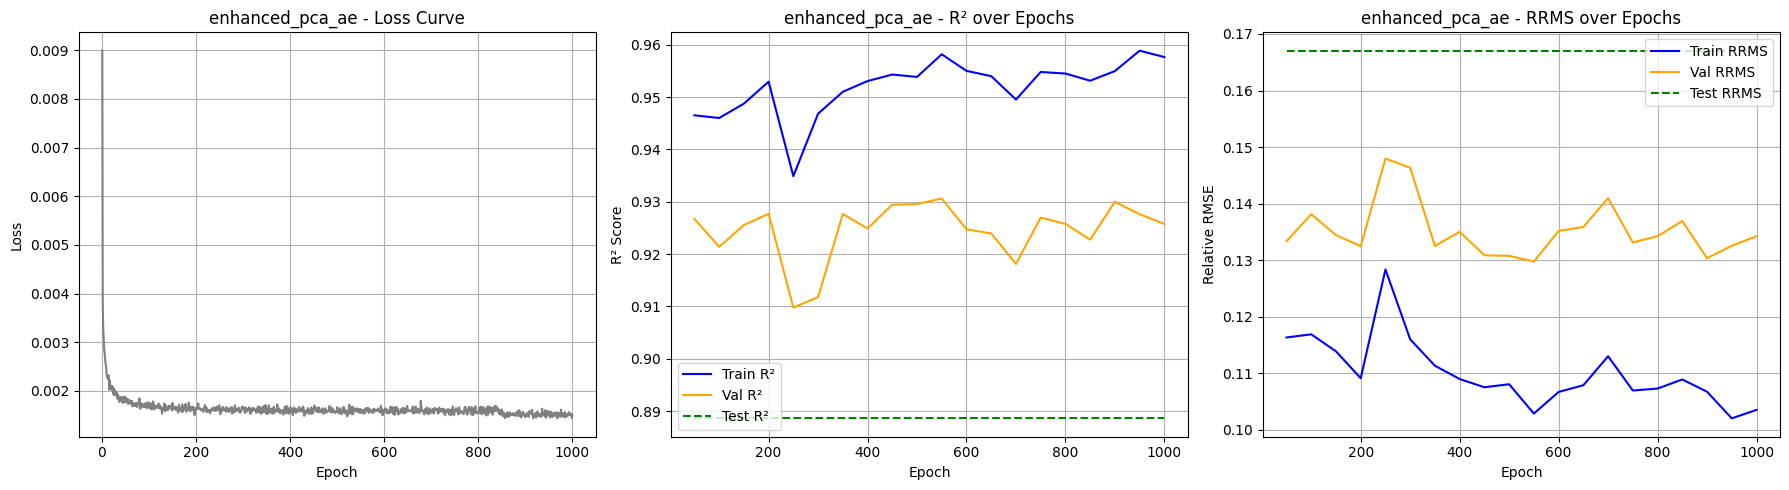

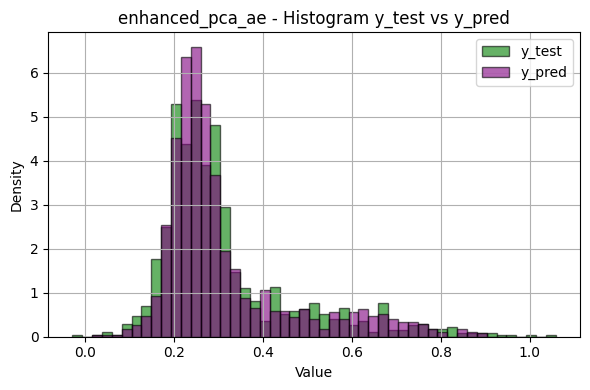

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 🔧 Configuración
epochs_total = 1000
epochs_step = 50
batch_size = 64
dropout_rate = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patience = 100

def relative_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.abs(np.mean(y_true))

def get_architecture(input_dim):
    if input_dim < 20: return (32, 16)
    elif input_dim < 50: return (64, 32)
    elif input_dim < 100: return (128, 64)
    elif input_dim < 200: return (256, 128, 64)
    elif input_dim < 400: return (512, 256, 64)
    else: return (1024, 512, 128, 64)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        for i, h in enumerate(hidden_layers):
            in_dim = input_size if i == 0 else hidden_layers[i - 1]
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_layers[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

results_dict = {}
architecture_map = {}

for key, data in datasets_loaded.items():
    if not all(k in data for k in ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test']):
        continue

    print(f"\n🧠 Training PyTorch MLP on: {key}")

    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']
    X_test, y_test = data['X_test'], data['y_test']

    input_dim = X_train.shape[1]
    arch = architecture_map.get(key, get_architecture(input_dim))
    architecture_map[key] = arch

    def ensure_numpy(y): return y.to_numpy() if hasattr(y, "to_numpy") else y

    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(ensure_numpy(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(ensure_numpy(y_val).reshape(-1, 1), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(ensure_numpy(y_test).reshape(-1, 1), dtype=torch.float32).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    model = MLP(input_dim, arch).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5)

    train_r2_hist, val_r2_hist = [], []
    train_rrmse_hist, val_rrmse_hist = [], []
    loss_hist = []
    best_state_dict = None
    best_val_rrmse = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, epochs_total + 1):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        loss_hist.append(epoch_loss / len(X_train))

        if epoch % epochs_step == 0 or epoch == epochs_total:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor).cpu().numpy().ravel()
                y_val_pred = model(X_val_tensor).cpu().numpy().ravel()

            train_r2 = r2_score(y_train, y_train_pred)
            val_r2 = r2_score(y_val, y_val_pred)
            train_rrmse = relative_rmse(y_train, y_train_pred)
            val_rrmse = relative_rmse(y_val, y_val_pred)

            train_r2_hist.append(train_r2)
            val_r2_hist.append(val_r2)
            train_rrmse_hist.append(train_rrmse)
            val_rrmse_hist.append(val_rrmse)

            scheduler.step(val_rrmse)

            if val_rrmse < best_val_rrmse:
                best_val_rrmse = val_rrmse
                best_state_dict = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"🛑 Early stopping at epoch {epoch}")
                    break

            print(f"  Epoch {epoch:4d} | Val R²: {val_r2:.3f}, Val RRMS: {val_rrmse:.3f}")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train_tensor).cpu().numpy().ravel()
        y_val_pred = model(X_val_tensor).cpu().numpy().ravel()
        y_test_pred = model(X_test_tensor).cpu().numpy().ravel()

    # === Save model and metadata
    model_path = f"{key}_mlp_model.pth"
    meta_path = f"{key}_mlp_meta.pkl"

    torch.save(model.state_dict(), model_path)
    model_metadata = {
        'input_features': list(X_train.columns),
        'architecture': arch,
        'trained_epochs': epoch,
        'final_val_rrmse': best_val_rrmse,
    }
    with open(meta_path, 'wb') as f:
        pickle.dump(model_metadata, f)

    final_metrics = {
        'architecture': arch,
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'train_rrmse': relative_rmse(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
        'val_rrmse': relative_rmse(y_val, y_val_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'test_rrmse': relative_rmse(y_test, y_test_pred),
        'loss_curve': loss_hist,
        'train_r2_hist': train_r2_hist,
        'val_r2_hist': val_r2_hist,
        'train_rrmse_hist': train_rrmse_hist,
        'val_rrmse_hist': val_rrmse_hist,
        'y_test': y_test,
        'y_pred': y_test_pred,
        'model_path': model_path,
        'meta_path': meta_path,
        'trained_epochs': epoch,
        'input_features': model_metadata['input_features']
    }

    results_dict[key] = final_metrics

    # === Plots
    epochs_sub = list(range(epochs_step, epochs_step * len(train_r2_hist) + 1, epochs_step))

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(loss_hist) + 1), loss_hist, color='gray')
    plt.title(f'{key} - Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_sub, train_r2_hist, label='Train R²', color='blue')
    plt.plot(epochs_sub, val_r2_hist, label='Val R²', color='orange')
    plt.hlines(final_metrics['test_r2'], epochs_sub[0], epochs_sub[-1], colors='green', linestyles='--', label='Test R²')
    plt.title(f'{key} - R² over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_sub, train_rrmse_hist, label='Train RRMS', color='blue')
    plt.plot(epochs_sub, val_rrmse_hist, label='Val RRMS', color='orange')
    plt.hlines(final_metrics['test_rrmse'], epochs_sub[0], epochs_sub[-1], colors='green', linestyles='--', label='Test RRMS')
    plt.title(f'{key} - RRMS over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Relative RMSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    bins = np.linspace(min(min(y_test), min(y_test_pred)), max(max(y_test), max(y_test_pred)), 50)
    plt.hist(y_test, bins=bins, alpha=0.6, label='y_test', edgecolor='black', density=True, color='green')
    plt.hist(y_test_pred, bins=bins, alpha=0.6, label='y_pred', edgecolor='black', density=True, color='purple')
    plt.title(f'{key} - Histogram y_test vs y_pred')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 🧪 Baseline MLP Training

This block trains a simple baseline MLP model on all loaded dataset versions. The architecture consists of two hidden layers with 64 and 32 units respectively, using ReLU activations. Key aspects include:

- **Fixed architecture**: A shallow and consistent network across datasets to serve as a performance baseline.
- **Standard training loop**: Trained for 500 epochs using the Adam optimizer and MSE loss.
- **Metric tracking**: Evaluation on train, validation, and test sets with R² and relative RMSE.
- **Result logging and visualization**: Saves metrics and architecture info, along with loss and prediction histograms.

This baseline helps quantify the incremental value of architectural depth and advanced preprocessing techniques.



🧠 Baseline MLP training on: raw
  Epoch   50 | Val R²: 0.865, Val RRMS: 0.178
  Epoch  100 | Val R²: 0.824, Val RRMS: 0.203
  Epoch  150 | Val R²: 0.830, Val RRMS: 0.200
  Epoch  200 | Val R²: 0.827, Val RRMS: 0.202
  Epoch  250 | Val R²: 0.834, Val RRMS: 0.197
  Epoch  300 | Val R²: 0.821, Val RRMS: 0.205
  Epoch  350 | Val R²: 0.822, Val RRMS: 0.205
  Epoch  400 | Val R²: 0.817, Val RRMS: 0.207
  Epoch  450 | Val R²: 0.818, Val RRMS: 0.207
  Epoch  500 | Val R²: 0.816, Val RRMS: 0.208


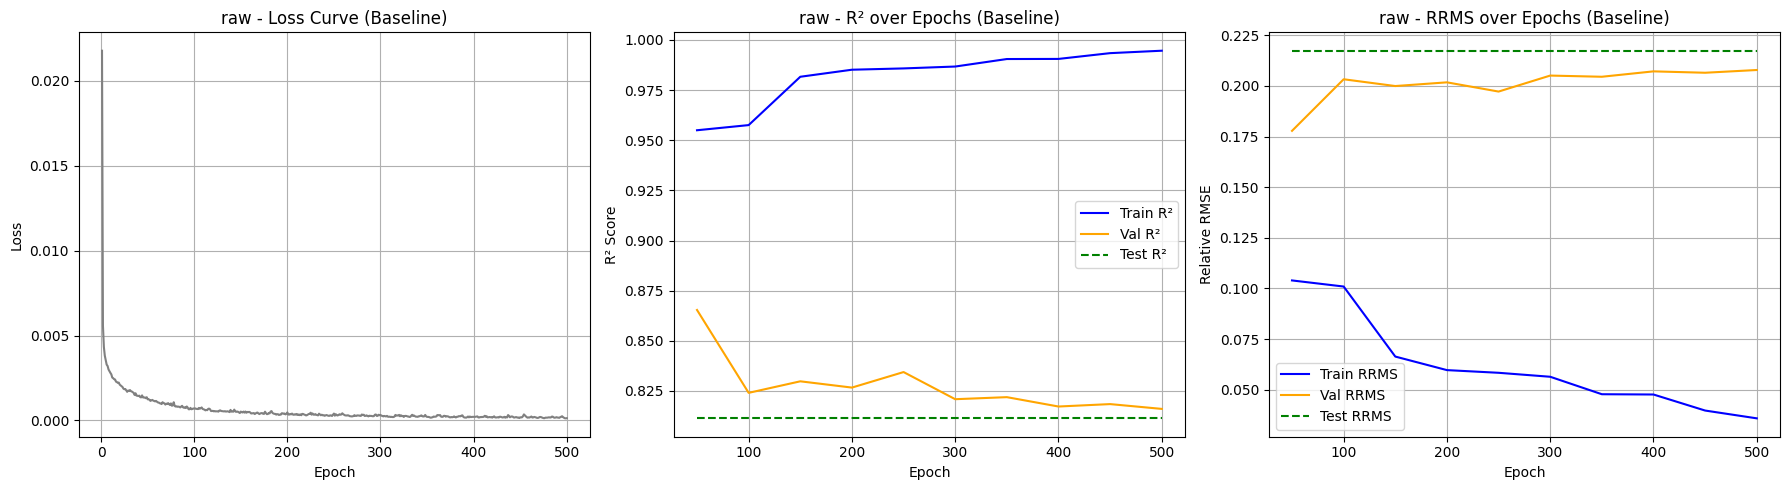

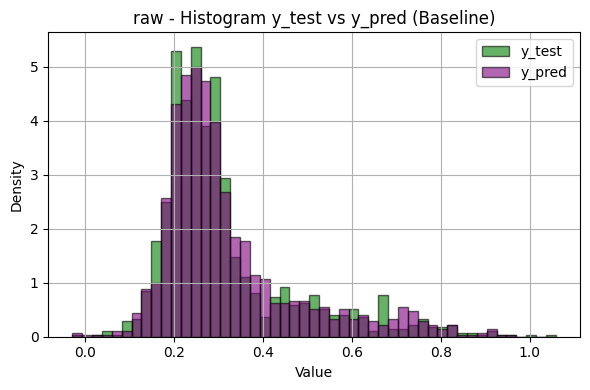


🧠 Baseline MLP training on: enhanced
  Epoch   50 | Val R²: 0.915, Val RRMS: 0.143
  Epoch  100 | Val R²: 0.911, Val RRMS: 0.147
  Epoch  150 | Val R²: 0.919, Val RRMS: 0.140
  Epoch  200 | Val R²: 0.907, Val RRMS: 0.150
  Epoch  250 | Val R²: 0.908, Val RRMS: 0.150
  Epoch  300 | Val R²: 0.909, Val RRMS: 0.148
  Epoch  350 | Val R²: 0.910, Val RRMS: 0.148
  Epoch  400 | Val R²: 0.906, Val RRMS: 0.151
  Epoch  450 | Val R²: 0.908, Val RRMS: 0.150
  Epoch  500 | Val R²: 0.907, Val RRMS: 0.151


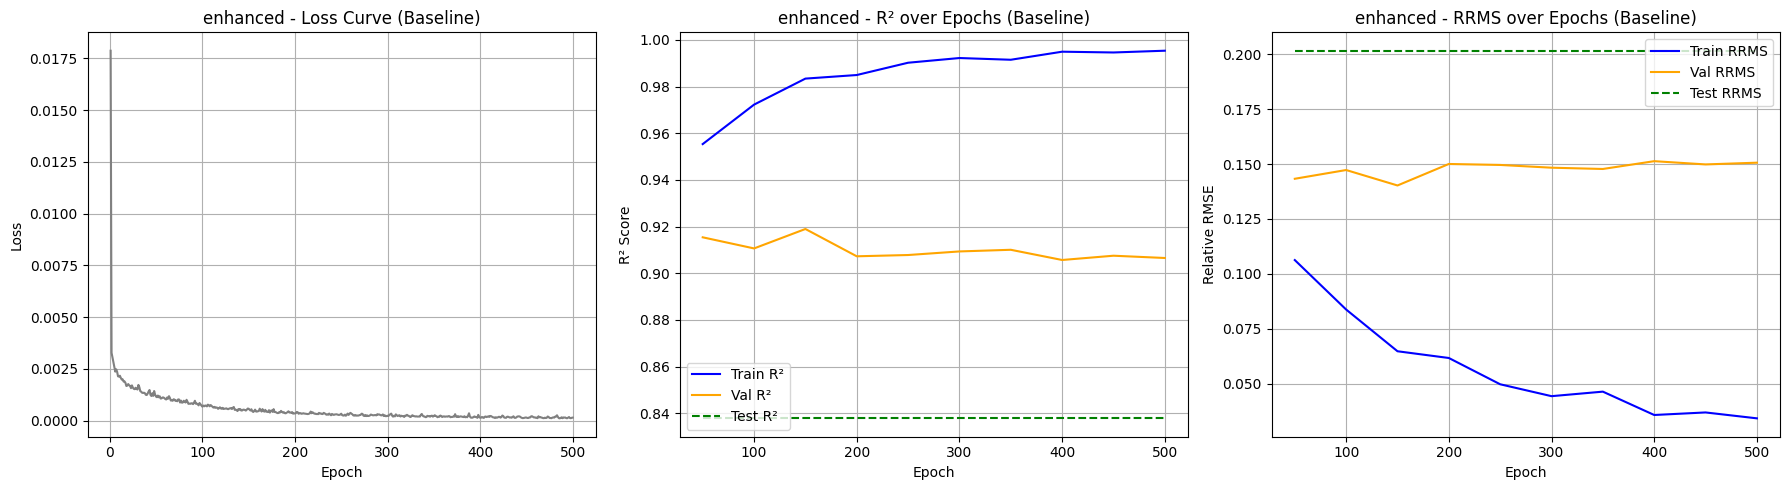

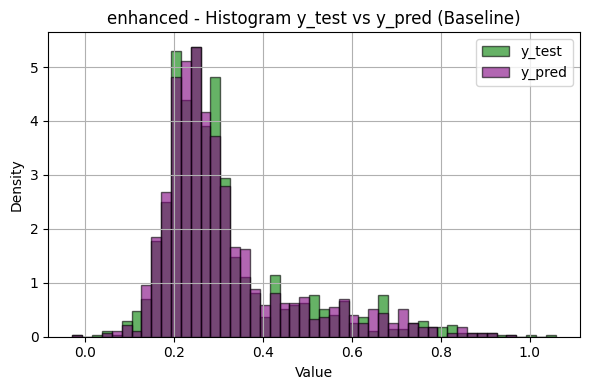


🧠 Baseline MLP training on: raw_pca
  Epoch   50 | Val R²: 0.860, Val RRMS: 0.182
  Epoch  100 | Val R²: 0.840, Val RRMS: 0.194
  Epoch  150 | Val R²: 0.830, Val RRMS: 0.200
  Epoch  200 | Val R²: 0.824, Val RRMS: 0.203
  Epoch  250 | Val R²: 0.818, Val RRMS: 0.207
  Epoch  300 | Val R²: 0.812, Val RRMS: 0.210
  Epoch  350 | Val R²: 0.811, Val RRMS: 0.211
  Epoch  400 | Val R²: 0.799, Val RRMS: 0.217
  Epoch  450 | Val R²: 0.790, Val RRMS: 0.222
  Epoch  500 | Val R²: 0.800, Val RRMS: 0.217


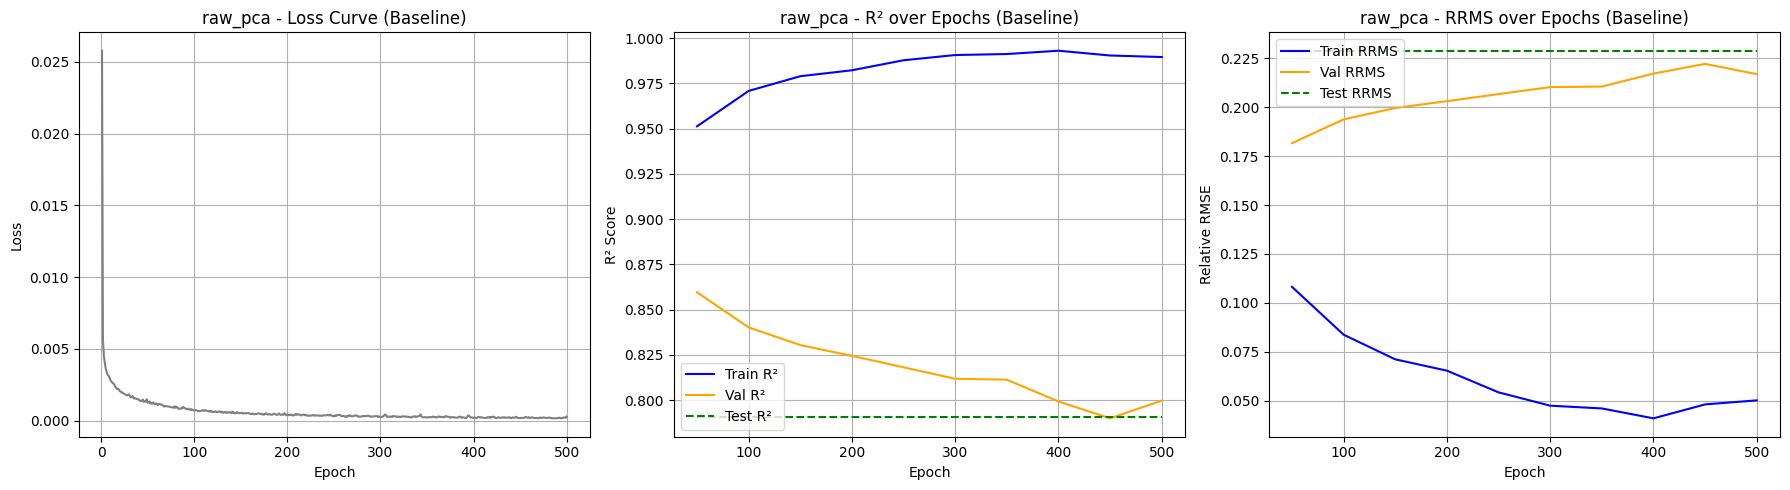

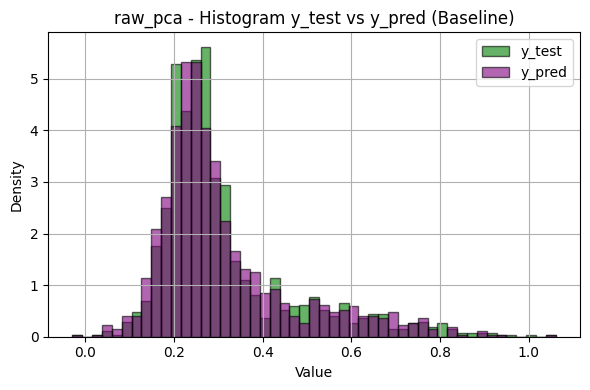


🧠 Baseline MLP training on: enhanced_pca
  Epoch   50 | Val R²: 0.911, Val RRMS: 0.147
  Epoch  100 | Val R²: 0.918, Val RRMS: 0.141
  Epoch  150 | Val R²: 0.914, Val RRMS: 0.145
  Epoch  200 | Val R²: 0.915, Val RRMS: 0.144
  Epoch  250 | Val R²: 0.913, Val RRMS: 0.146
  Epoch  300 | Val R²: 0.909, Val RRMS: 0.148
  Epoch  350 | Val R²: 0.912, Val RRMS: 0.146
  Epoch  400 | Val R²: 0.910, Val RRMS: 0.148
  Epoch  450 | Val R²: 0.909, Val RRMS: 0.148
  Epoch  500 | Val R²: 0.910, Val RRMS: 0.148


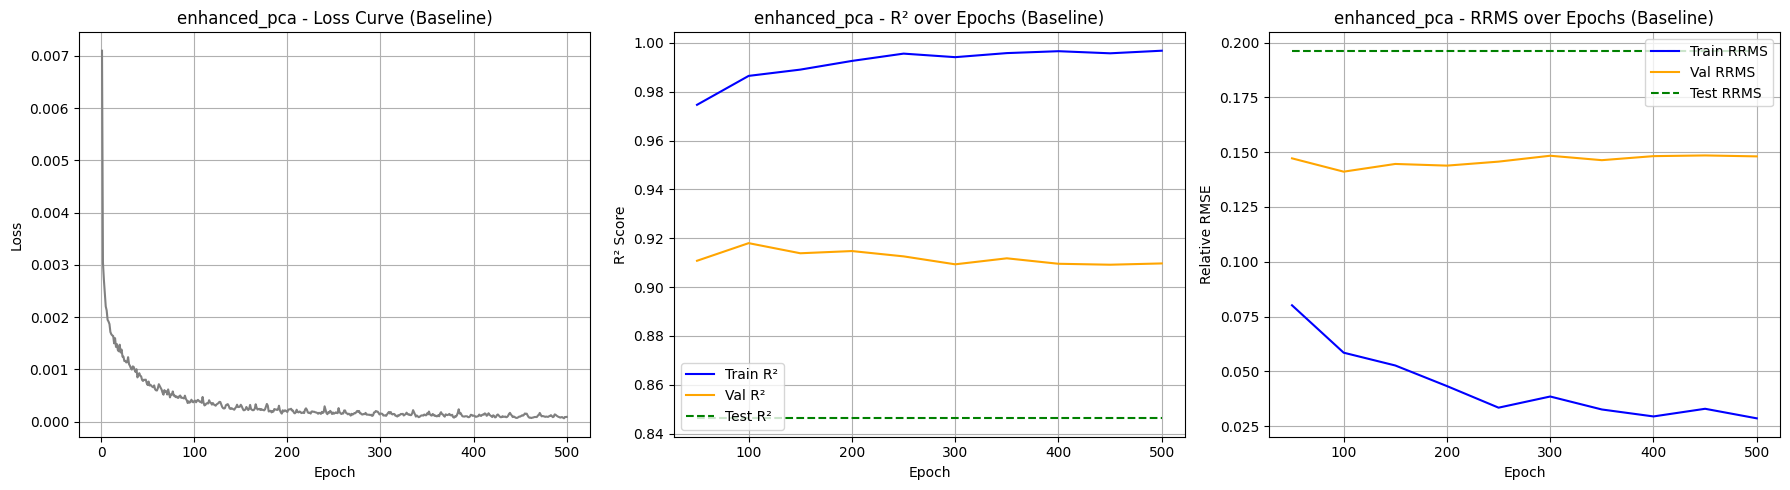

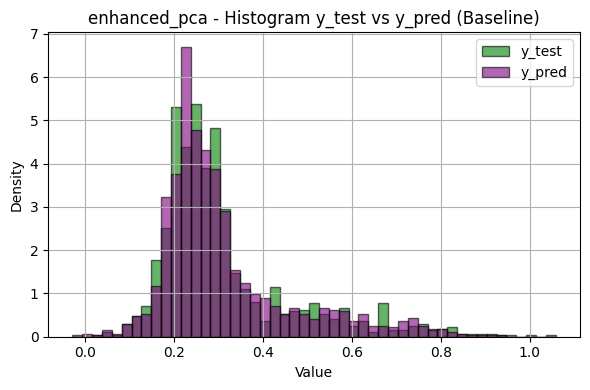


🧠 Baseline MLP training on: raw_ae
  Epoch   50 | Val R²: 0.868, Val RRMS: 0.176
  Epoch  100 | Val R²: 0.871, Val RRMS: 0.174
  Epoch  150 | Val R²: 0.861, Val RRMS: 0.181
  Epoch  200 | Val R²: 0.844, Val RRMS: 0.192
  Epoch  250 | Val R²: 0.848, Val RRMS: 0.189
  Epoch  300 | Val R²: 0.846, Val RRMS: 0.190
  Epoch  350 | Val R²: 0.834, Val RRMS: 0.197
  Epoch  400 | Val R²: 0.836, Val RRMS: 0.197
  Epoch  450 | Val R²: 0.824, Val RRMS: 0.203
  Epoch  500 | Val R²: 0.831, Val RRMS: 0.199


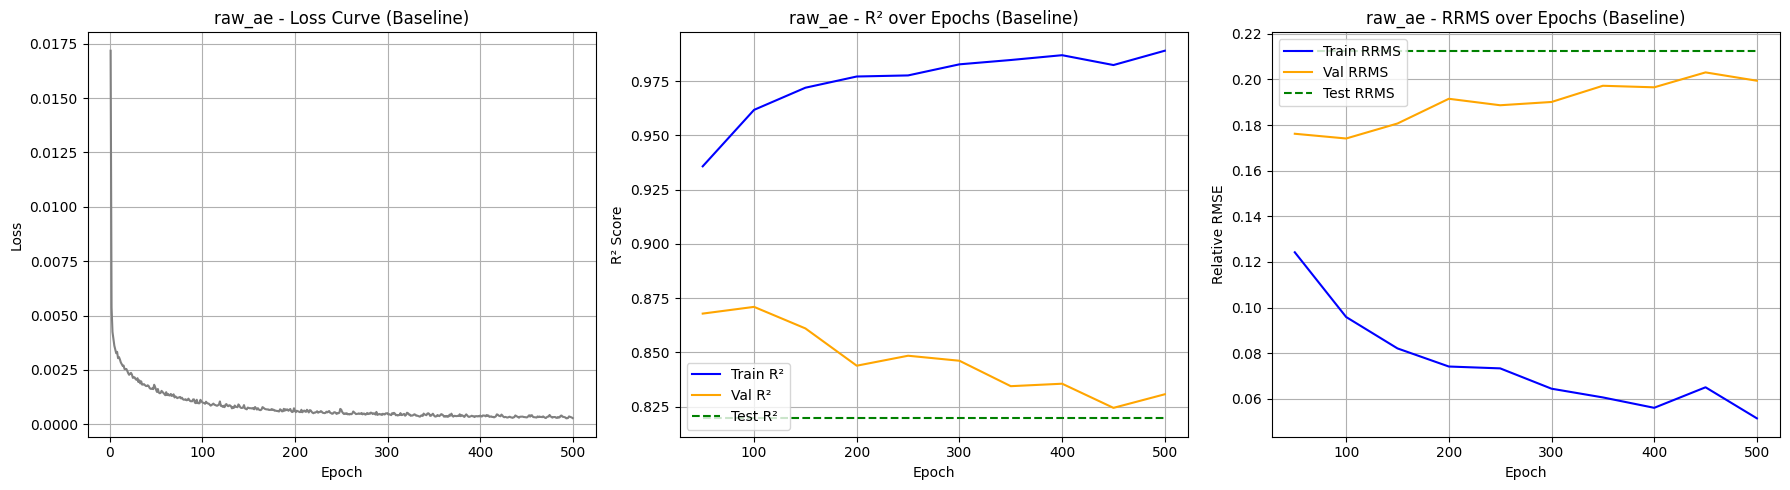

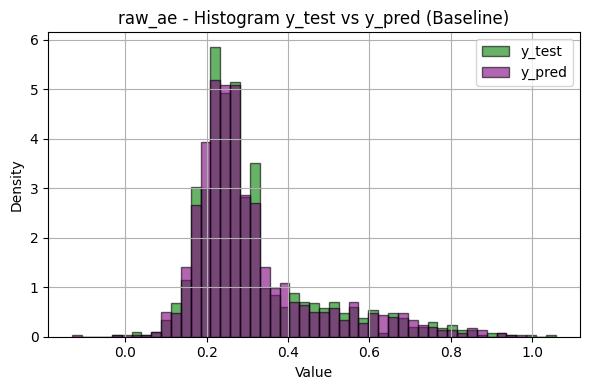


🧠 Baseline MLP training on: enhanced_ae
  Epoch   50 | Val R²: 0.914, Val RRMS: 0.144
  Epoch  100 | Val R²: 0.921, Val RRMS: 0.139
  Epoch  150 | Val R²: 0.919, Val RRMS: 0.140
  Epoch  200 | Val R²: 0.921, Val RRMS: 0.139
  Epoch  250 | Val R²: 0.920, Val RRMS: 0.139
  Epoch  300 | Val R²: 0.920, Val RRMS: 0.139
  Epoch  350 | Val R²: 0.920, Val RRMS: 0.139
  Epoch  400 | Val R²: 0.921, Val RRMS: 0.138
  Epoch  450 | Val R²: 0.918, Val RRMS: 0.141
  Epoch  500 | Val R²: 0.921, Val RRMS: 0.138


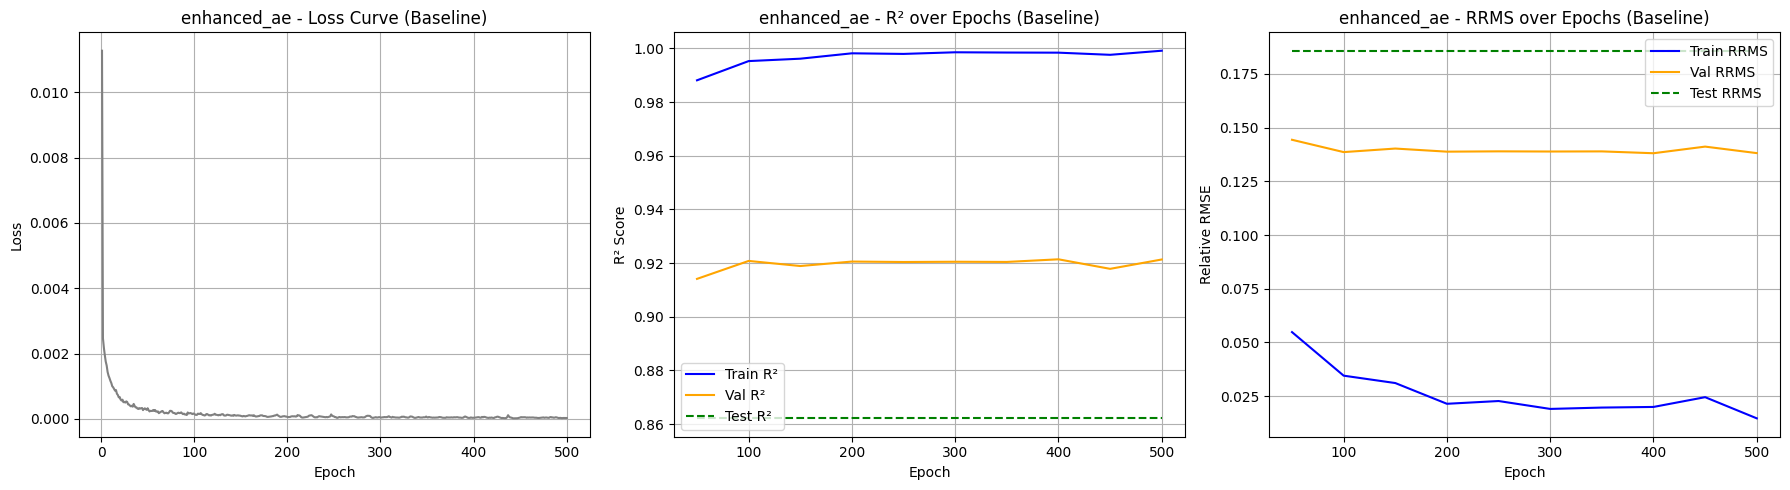

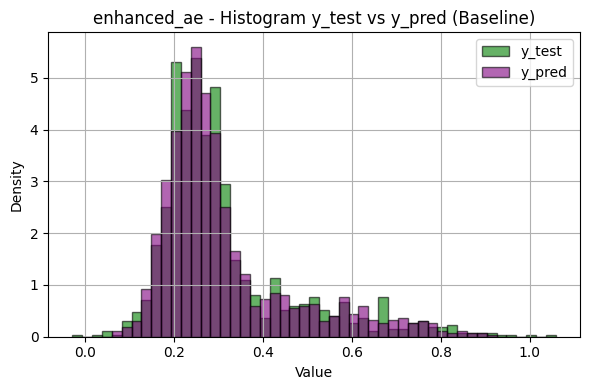


🧠 Baseline MLP training on: raw_pca_ae
  Epoch   50 | Val R²: 0.865, Val RRMS: 0.178
  Epoch  100 | Val R²: 0.874, Val RRMS: 0.172
  Epoch  150 | Val R²: 0.864, Val RRMS: 0.179
  Epoch  200 | Val R²: 0.854, Val RRMS: 0.185
  Epoch  250 | Val R²: 0.859, Val RRMS: 0.182
  Epoch  300 | Val R²: 0.844, Val RRMS: 0.191
  Epoch  350 | Val R²: 0.846, Val RRMS: 0.190
  Epoch  400 | Val R²: 0.845, Val RRMS: 0.191
  Epoch  450 | Val R²: 0.837, Val RRMS: 0.196
  Epoch  500 | Val R²: 0.845, Val RRMS: 0.191


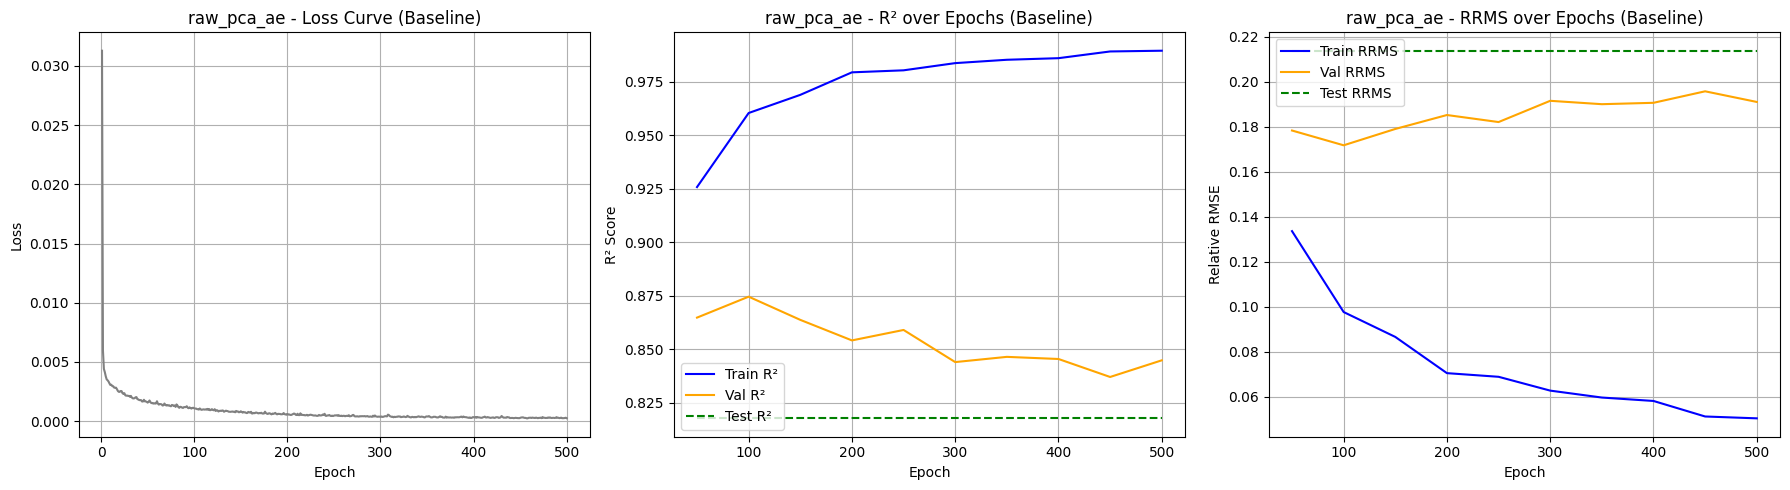

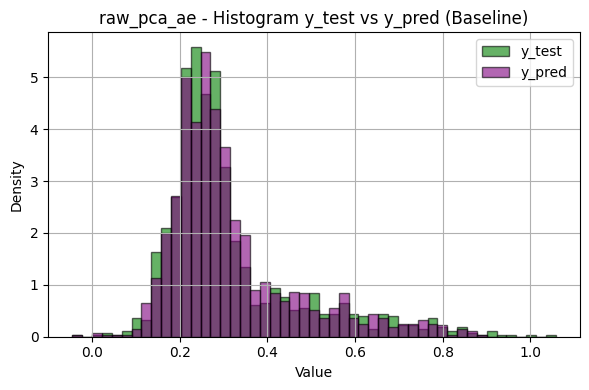


🧠 Baseline MLP training on: enhanced_pca_ae
  Epoch   50 | Val R²: 0.918, Val RRMS: 0.141
  Epoch  100 | Val R²: 0.913, Val RRMS: 0.145
  Epoch  150 | Val R²: 0.910, Val RRMS: 0.148
  Epoch  200 | Val R²: 0.910, Val RRMS: 0.148
  Epoch  250 | Val R²: 0.911, Val RRMS: 0.147
  Epoch  300 | Val R²: 0.915, Val RRMS: 0.144
  Epoch  350 | Val R²: 0.913, Val RRMS: 0.146
  Epoch  400 | Val R²: 0.911, Val RRMS: 0.147
  Epoch  450 | Val R²: 0.912, Val RRMS: 0.146
  Epoch  500 | Val R²: 0.910, Val RRMS: 0.147


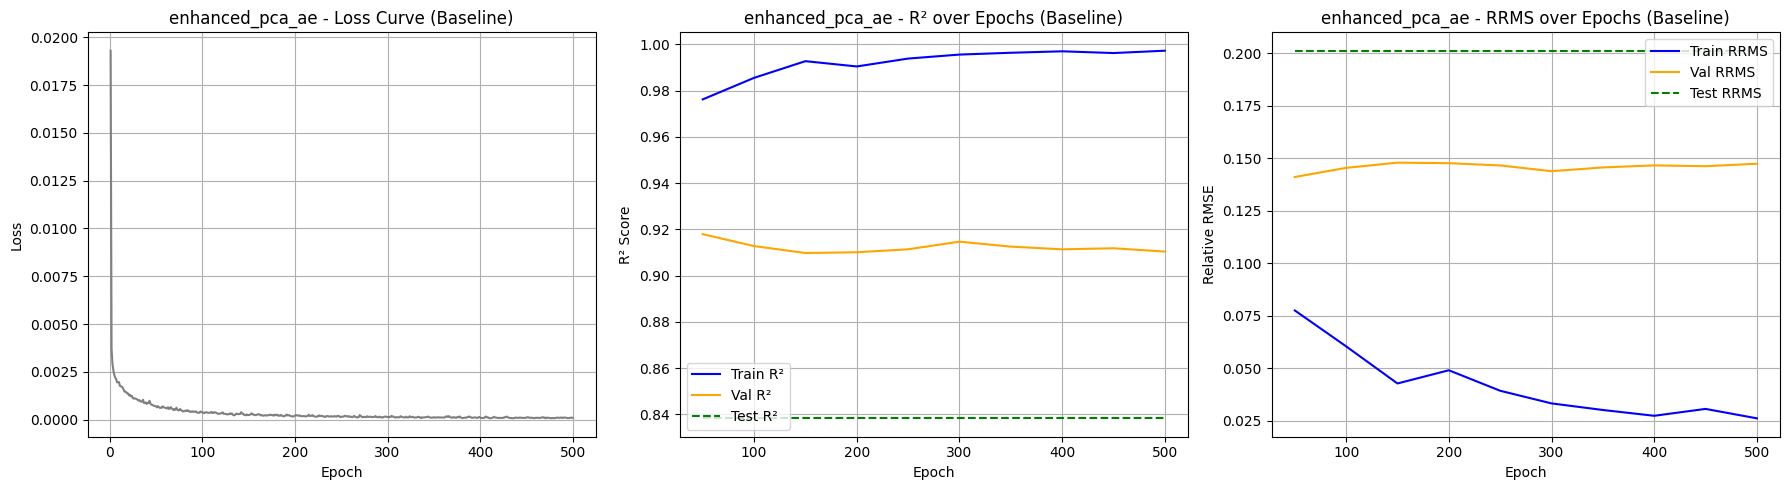

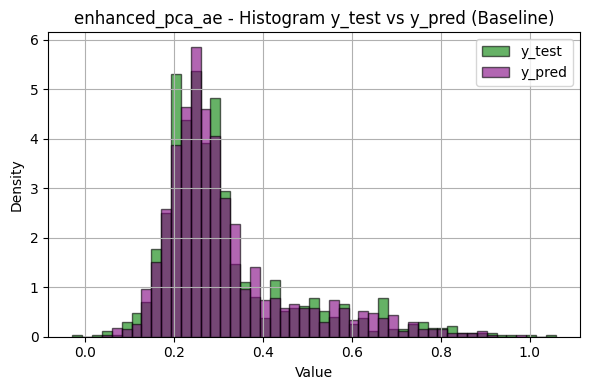

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 📌 Configuración
epochs_total = 500
epochs_step = 50
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📊 Métrica personalizada
def relative_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.abs(np.mean(y_true))

# 🧠 MLP Baseline
class BaselineMLP(nn.Module):
    def __init__(self, input_size):
        super(BaselineMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# 📦 Resultados
results_dict_baseline = {}

for label, data in datasets_loaded.items():
    if not all(k in data for k in ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test']):
        continue

    print(f"\n🧠 Baseline MLP training on: {label}")

    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']
    X_test, y_test = data['X_test'], data['y_test']

    input_dim = X_train.shape[1]

    def ensure_numpy(y):
        return y.to_numpy() if hasattr(y, "to_numpy") else y

    # 📦 Tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(ensure_numpy(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(ensure_numpy(y_val).reshape(-1, 1), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(ensure_numpy(y_test).reshape(-1, 1), dtype=torch.float32).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    model = BaselineMLP(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_r2_hist, val_r2_hist = [], []
    train_rrmse_hist, val_rrmse_hist = [], []
    loss_hist = []

    for epoch in range(1, epochs_total + 1):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        loss_hist.append(epoch_loss / len(X_train))

        if epoch % epochs_step == 0 or epoch == epochs_total:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor).cpu().numpy().ravel()
                y_val_pred = model(X_val_tensor).cpu().numpy().ravel()

            train_r2 = r2_score(y_train, y_train_pred)
            val_r2 = r2_score(y_val, y_val_pred)
            train_rrmse = relative_rmse(y_train, y_train_pred)
            val_rrmse = relative_rmse(y_val, y_val_pred)

            train_r2_hist.append(train_r2)
            val_r2_hist.append(val_r2)
            train_rrmse_hist.append(train_rrmse)
            val_rrmse_hist.append(val_rrmse)

            print(f"  Epoch {epoch:4d} | Val R²: {val_r2:.3f}, Val RRMS: {val_rrmse:.3f}")

    # === Final evaluation
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train_tensor).cpu().numpy().ravel()
        y_val_pred = model(X_val_tensor).cpu().numpy().ravel()
        y_test_pred = model(X_test_tensor).cpu().numpy().ravel()

    # === Save model and metadata
    model_path = f"{label}_baseline_mlp_model.pth"
    meta_path = f"{label}_baseline_mlp_meta.pkl"

    torch.save(model.state_dict(), model_path)
    model_metadata = {
        'input_features': list(X_train.columns),
        'architecture': (64, 32),
        'trained_epochs': epochs_total,
    }
    with open(meta_path, 'wb') as f:
        pickle.dump(model_metadata, f)

    # === Collect final metrics
    final_metrics = {
        'architecture': model_metadata['architecture'],
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'train_rrmse': relative_rmse(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
        'val_rrmse': relative_rmse(y_val, y_val_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'test_rrmse': relative_rmse(y_test, y_test_pred),
        'loss_curve': loss_hist,
        'train_r2_hist': train_r2_hist,
        'val_r2_hist': val_r2_hist,
        'train_rrmse_hist': train_rrmse_hist,
        'val_rrmse_hist': val_rrmse_hist,
        'y_test': y_test,
        'y_pred': y_test_pred,
        'model_path': model_path,
        'meta_path': meta_path,
        'trained_epochs': epochs_total,
        'input_features': model_metadata['input_features']
    }


    results_dict_baseline[label] = final_metrics

    # === Plots
    epochs_sub = list(range(epochs_step, epochs_step * len(train_r2_hist) + 1, epochs_step))

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(loss_hist) + 1), loss_hist, color='gray')
    plt.title(f'{label} - Loss Curve (Baseline)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_sub, train_r2_hist, label='Train R²', color='blue')
    plt.plot(epochs_sub, val_r2_hist, label='Val R²', color='orange')
    plt.hlines(final_metrics['test_r2'], epochs_sub[0], epochs_sub[-1], colors='green', linestyles='--', label='Test R²')
    plt.title(f'{label} - R² over Epochs (Baseline)')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_sub, train_rrmse_hist, label='Train RRMS', color='blue')
    plt.plot(epochs_sub, val_rrmse_hist, label='Val RRMS', color='orange')
    plt.hlines(final_metrics['test_rrmse'], epochs_sub[0], epochs_sub[-1], colors='green', linestyles='--', label='Test RRMS')
    plt.title(f'{label} - RRMS over Epochs (Baseline)')
    plt.xlabel('Epoch')
    plt.ylabel('Relative RMSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Histogram
    plt.figure(figsize=(6, 4))
    bins = np.linspace(min(min(y_test), min(y_test_pred)), max(max(y_test), max(y_test_pred)), 50)
    plt.hist(y_test, bins=bins, alpha=0.6, label='y_test', edgecolor='black', density=True, color='green')
    plt.hist(y_test_pred, bins=bins, alpha=0.6, label='y_pred', edgecolor='black', density=True, color='purple')
    plt.title(f'{label} - Histogram y_test vs y_pred (Baseline)')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 📊 Summary of MLP vs. Baseline Performance

This final section provides a side-by-side summary of model metrics across all dataset variants for both the **baseline MLP** and the **deeper MLP architecture**. Key evaluation metrics include R², RRMSE, and MSE for training, validation, and test sets.

- Datasets are sorted by **Test R²** to highlight generalization performance.
- The number of training epochs is recorded to monitor convergence behavior.
- These summaries allow direct comparison of how architectural complexity and feature representations (raw, enhanced, PCA, AE, etc.) influenced predictive performance.

This table serves as a concise benchmarking tool for evaluating modeling choices throughout the pipeline.


In [ ]:
from IPython.display import display, Markdown

# --- MLP Summary ---
mlp_summary = []
for key, res in results_dict.items():
    mlp_summary.append({
        "Dataset": key,
        "Train_R2": res['train_r2'],
        "Val_R2": res['val_r2'],
        "Test_R2": res['test_r2'],
        "Train_RRMSE": res['train_rrmse'],
        "Val_RRMSE": res['val_rrmse'],
        "Test_RRMSE": res['test_rrmse'],
        "Train_MSE": res['train_mse'],
        "Val_MSE": res['val_mse'],
        "Test_MSE": res['test_mse'],
        "Epochs": res.get("trained_epochs", "n/a")
    })
mlp_df = pd.DataFrame(mlp_summary).sort_values("Test_R2", ascending=False)
display(Markdown("### 📋 MLP Summary Table"))
display(mlp_df.style.set_table_attributes("style='display:inline'").hide(axis="index"))

# --- Baseline Summary ---
baseline_summary = []
for key, res in results_dict_baseline.items():
    baseline_summary.append({
        "Dataset": key,
        "Train_R2": res['train_r2'],
        "Val_R2": res['val_r2'],
        "Test_R2": res['test_r2'],
        "Train_RRMSE": res['train_rrmse'],
        "Val_RRMSE": res['val_rrmse'],
        "Test_RRMSE": res['test_rrmse'],
        "Train_MSE": res['train_mse'],
        "Val_MSE": res['val_mse'],
        "Test_MSE": res['test_mse'],
        "Epochs": res.get("trained_epochs", "n/a")
    })
baseline_df = pd.DataFrame(baseline_summary).sort_values("Test_R2", ascending=False)
display(Markdown("### 📋 Baseline Summary Table"))
display(baseline_df.style.set_table_attributes("style='display:inline'").hide(axis="index"))



### 📋 MLP Summary Table

### 📋 Baseline Summary Table

## 🧪 Per-Type Evaluation — Combined R² + RRMSE Score

This section analyzes how well each model performs across **individual cement types** using a combined score that balances **mean R²** and **mean RRMSE** across categories.

- For each dataset, the performance is broken down by `Type_*` dummy variables.
- The best 3 datasets (per model) are ranked using a normalized composite score.
- Tables provide detailed metrics per cement type, helping to understand where the model generalizes well or struggles.
- This insight supports model selection not just by overall performance, but by **robustness across cement formulations**.

We repeat this analysis separately for:
- 🔹 **MLP (Deep Architecture)**
- 🔸 **Baseline MLP**

This approach emphasizes not just raw accuracy, but **fairness and consistency** across diverse real-world formulations.


In [ ]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def per_type_metrics_combined_score(results_dict, datasets_loaded, title="MLP"):
    display(Markdown(f"## 📌 Per-Type Metrics — Combined Score (R² + RRMSE) — {title}"))

    dataset_scores = []

    # Step 1: Compute per-dataset mean R² and RRMSE (per type)
    per_dataset_stats = []

    for key, res in results_dict.items():
        data = datasets_loaded.get(key)
        if data is None:
            continue

        X_test = data['X_test'].copy()
        y_true = pd.Series(res['y_test'], index=X_test.index)
        y_pred = pd.Series(res['y_pred'], index=X_test.index)

        type_cols = [c for c in X_test.columns if c.startswith("Type_")]
        r2_list, rrmse_list = [], []

        for col in type_cols:
            mask = X_test[col] == 1
            if not mask.index.equals(y_true.index):
                mask = mask.reindex(y_true.index)

            y_t = y_true[mask]
            y_p = y_pred[mask]

            if len(y_t) >= 10:
                r2_list.append(r2_score(y_t, y_p))
                rrmse_list.append(relative_rmse(y_t, y_p))

        if r2_list and rrmse_list:
            per_dataset_stats.append({
                'key': key,
                'mean_r2': np.mean(r2_list),
                'mean_rrmse': np.mean(rrmse_list),
                'r2s': r2_list,
                'rrmses': rrmse_list
            })

    if not per_dataset_stats:
        display(Markdown("⚠️ No datasets with valid Type_ groups."))
        return

    # Step 2: Global normalization
    r2_means = [d['mean_r2'] for d in per_dataset_stats]
    rrmse_means = [d['mean_rrmse'] for d in per_dataset_stats]

    r2_mean_global, r2_std = np.mean(r2_means), np.std(r2_means)
    rrmse_mean_global, rrmse_std = np.mean(rrmse_means), np.std(rrmse_means)

    for d in per_dataset_stats:
        norm_r2 = (d['mean_r2'] - r2_mean_global) / (r2_std + 1e-8)
        norm_rrmse = (rrmse_mean_global - d['mean_rrmse']) / (rrmse_std + 1e-8)
        score = 0.5 * norm_r2 + 0.5 * norm_rrmse
        d['score'] = score

    # Apply min-max normalization to scores
    all_scores = [d['score'] for d in per_dataset_stats]
    min_score, max_score = min(all_scores), max(all_scores)
    for d in per_dataset_stats:
        d['score'] = (d['score'] - min_score) / (max_score - min_score + 1e-8)

    # Step 3: Sort by combined score and show top 3
    top_datasets = sorted(per_dataset_stats, key=lambda x: x['score'], reverse=True)[:3]

    for d in top_datasets:
        key = d['key']
        display(Markdown(f"### 📂 Dataset: `{key}`"))
        display(Markdown(
            f"**Mean R²**: `{d['mean_r2']:.4f}`  \n"
            f"**Mean RRMSE**: `{d['mean_rrmse']:.4f}`  \n"
            f"**Combined Score**: `{d['score']:.4f}`"
        ))

        # Detailed per-type metrics
        X_test = datasets_loaded[key]['X_test'].copy()
        y_true = pd.Series(results_dict[key]['y_test'], index=X_test.index)
        y_pred = pd.Series(results_dict[key]['y_pred'], index=X_test.index)

        rows = []
        for col in [c for c in X_test.columns if c.startswith("Type_")]:
            mask = X_test[col] == 1
            if not mask.index.equals(y_true.index):
                mask = mask.reindex(y_true.index)

            y_t = y_true[mask]
            y_p = y_pred[mask]

            if len(y_t) < 10:
                continue

            rows.append({
                "Dataset": key,
                "Type": col,
                "Samples": len(y_t),
                "R2": r2_score(y_t, y_p),
                "RRMSE": relative_rmse(y_t, y_p),
                "MSE": mean_squared_error(y_t, y_p)
            })

        df = pd.DataFrame(rows).sort_values("R2", ascending=False)
        display(df.style.set_table_attributes("style='display:inline'").hide(axis="index"))

# ✅ Run for both models
per_type_metrics_combined_score(results_dict, datasets_loaded, title="MLP")
per_type_metrics_combined_score(results_dict_baseline, datasets_loaded, title="Baseline")


## 📌 Per-Type Metrics — Combined Score (R² + RRMSE) — MLP

### 📂 Dataset: `enhanced_pca_ae`

**Mean R²**: `0.5443`  
**Mean RRMSE**: `0.1535`  
**Combined Score**: `1.0000`

### 📂 Dataset: `raw`

**Mean R²**: `0.5344`  
**Mean RRMSE**: `0.1528`  
**Combined Score**: `0.9527`

### 📂 Dataset: `enhanced_ae`

**Mean R²**: `0.5330`  
**Mean RRMSE**: `0.1536`  
**Combined Score**: `0.9147`

## 📌 Per-Type Metrics — Combined Score (R² + RRMSE) — Baseline

### 📂 Dataset: `enhanced_pca`

**Mean R²**: `0.3657`  
**Mean RRMSE**: `0.1734`  
**Combined Score**: `1.0000`

### 📂 Dataset: `enhanced_ae`

**Mean R²**: `0.3375`  
**Mean RRMSE**: `0.1816`  
**Combined Score**: `0.8382`

### 📂 Dataset: `enhanced_pca_ae`

**Mean R²**: `0.2697`  
**Mean RRMSE**: `0.1898`  
**Combined Score**: `0.6060`